# Imports

In [546]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, \
    precision_score, recall_score, plot_precision_recall_curve, \
    classification_report, PrecisionRecallDisplay, RocCurveDisplay, precision_recall_curve, \
    confusion_matrix, matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score, \
    f1_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator

from imblearn.under_sampling import TomekLinks, NearMiss # ресемплеры

from catboost import CatBoostClassifier, Pool

import optuna # для оптимизации гиперпараметров

from typing import List, Dict, Tuple, Callable
pd.set_option('display.max_columns', None)


# Load data

In [2]:
DATA_PATH = 'dataset.csv'

In [16]:
data = pd.read_csv(DATA_PATH, delimiter=';')

In [17]:
data.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


# Basic clean & EDA  
+ Посмотрим на данные
+ почистим от пропусков
+ заэнкодим категориальные фичи
+ __подумаем, какую модель строить и какие метрики считать__

In [18]:
data = data.drop(columns=['uuid'])
TARGET = 'default'

In [19]:
print(f"Rows: {data.shape[0]}\nColumns: {data.shape[1]}")

Rows: 99976
Columns: 42


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   default                              89976 non-null  float64
 1   account_amount_added_12_24m          99976 non-null  int64  
 2   account_days_in_dc_12_24m            88140 non-null  float64
 3   account_days_in_rem_12_24m           88140 non-null  float64
 4   account_days_in_term_12_24m          88140 non-null  float64
 5   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 6   account_status                       45603 non-null  float64
 7   account_worst_status_0_3m            45603 non-null  float64
 8   account_worst_status_12_24m          33215 non-null  float64
 9   account_worst_status_3_6m            42274 non-null  float64
 10  account_worst_status_6_12m           39626 non-null  float64
 11  age                         

Видим, что есть много колонок с большим количеством пропусков, имеются категориальные фичи

__Исследуем подробнее__

In [21]:
data.describe()

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
count,89976.000000,9.997600e+04,88140.000000,88140.000000,88140.000000,40661.000000,45603.000000,45603.000000,33215.000000,42274.000000,...,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,9.997600e+04,99976.000000,30461.000000
mean,0.014315,1.225515e+04,0.223043,5.044622,0.286896,1.331292,1.042168,1.172905,1.337348,1.185291,...,0.744299,0.800582,1.052233,1.226164,4.035429,10816.065386,6542.895325,3.920880e+04,15.329780,1.121762
std,0.118786,3.548148e+04,5.808117,22.863971,2.929910,26.482299,0.202713,0.420142,0.575043,0.443309,...,0.634912,0.719946,0.786121,0.833502,163.934564,26463.972170,19041.223585,9.064929e+04,5.031360,0.343660
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000278,1.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.600000e+03,11.622708,1.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.152082,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.599500e+04,15.792778,1.000000
75%,0.000000,4.937250e+03,0.000000,0.000000,0.000000,0.662952,1.000000,1.000000,2.000000,1.000000,...,1.000000,1.000000,1.000000,2.000000,0.000000,9029.750000,85.000000,4.384425e+04,19.542014,1.000000
max,1.000000,1.128775e+06,365.000000,365.000000,97.000000,3914.000000,4.000000,4.000000,4.000000,4.000000,...,5.000000,3.000000,5.000000,5.000000,36479.000000,571475.000000,341859.000000,2.962870e+06,23.999722,3.000000


## NaN's

In [22]:
nans_df = data.isna().sum().sort_values(ascending=False)
nans_df = nans_df[nans_df > 0]
high_gap_features = list(nans_df.index)
nans_df

worst_status_active_inv                69515
account_worst_status_12_24m            66761
account_worst_status_6_12m             60350
account_incoming_debt_vs_paid_0_24m    59315
account_worst_status_3_6m              57702
account_status                         54373
account_worst_status_0_3m              54373
avg_payment_span_0_3m                  49305
avg_payment_span_0_12m                 23836
num_active_div_by_paid_inv_0_12m       22939
num_arch_written_off_12_24m            18078
num_arch_written_off_0_12m             18078
account_days_in_dc_12_24m              11836
account_days_in_rem_12_24m             11836
account_days_in_term_12_24m            11836
default                                10000
dtype: int64

In [23]:
def get_value_counts(features: List[str], data: pd.DataFrame):
    for feature in features:
        value = dict(data.loc[:, feature].value_counts(dropna=False))
        if len(value.keys()) < 10:
            print(f"{feature}: ", value)

In [24]:
get_value_counts(high_gap_features, data)

worst_status_active_inv:  {nan: 69515, 1.0: 26922, 2.0: 3369, 3.0: 170}
account_worst_status_12_24m:  {nan: 66761, 1.0: 23527, 2.0: 8433, 3.0: 993, 4.0: 262}
account_worst_status_6_12m:  {nan: 60350, 1.0: 30703, 2.0: 8025, 3.0: 688, 4.0: 210}
account_worst_status_3_6m:  {nan: 57702, 1.0: 35254, 2.0: 6357, 3.0: 513, 4.0: 150}
account_status:  {nan: 54373, 1.0: 43693, 2.0: 1900, 3.0: 7, 4.0: 3}
account_worst_status_0_3m:  {nan: 54373, 1.0: 38375, 2.0: 6678, 3.0: 443, 4.0: 107}
num_arch_written_off_12_24m:  {0.0: 81887, nan: 18078, 1.0: 9, 2.0: 2}
num_arch_written_off_0_12m:  {0.0: 81888, nan: 18078, 1.0: 10}
default:  {0.0: 88688, nan: 10000, 1.0: 1288}


Пропуски в таргете скорее всего означают, что дефолта не было, поэтому для *таргета* заполним пропуски __нулями__.  
Для *остальных колонок* лучше всего будет заполнить пропуски __модой__, т.к. везде преобладает какое-то одно значение, зачастую это значение __0__

In [25]:
data.loc[:, TARGET] = data[TARGET].fillna(0)
high_gap_features.remove('default')

['worst_status_active_inv',
 'account_worst_status_12_24m',
 'account_worst_status_6_12m',
 'account_incoming_debt_vs_paid_0_24m',
 'account_worst_status_3_6m',
 'account_status',
 'account_worst_status_0_3m',
 'avg_payment_span_0_3m',
 'avg_payment_span_0_12m',
 'num_active_div_by_paid_inv_0_12m',
 'num_arch_written_off_12_24m',
 'num_arch_written_off_0_12m',
 'account_days_in_dc_12_24m',
 'account_days_in_rem_12_24m',
 'account_days_in_term_12_24m']

In [46]:
def fill_na_with_mode(feature: str, data: pd.DataFrame):
    
    column = data.loc[:, [feature]]
    mode = column.mode().iloc[0,0]
    column = column.fillna(mode)
    
    return column

In [49]:
for feature in high_gap_features:
    data.loc[:, feature] = fill_na_with_mode(feature, data)

data.isna().sum().sum()

0

Заменим булевые значения в столбце *has_paid* на *int*

In [50]:
data.has_paid = data.has_paid.astype(int)

## Target rate

In [51]:
target_rate = data.default.value_counts()
print(f"0 class is {target_rate[0]/data.shape[0]}")
print(f"1 class is {target_rate[1]/data.shape[0]}")


0 class is 0.987116908057934
1 class is 0.012883091942066096


In [52]:
target_rate

0.0    98688
1.0     1288
Name: default, dtype: int64

Наблюдаем __сильнейший дизбаланс классов__.  
Это накладывает ограничения на возможные метрики для оценки (исключает accuracy), а так же на схему обучения -- скорее всего придется использовать __over/under sampling__.

## Correlations

In [57]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

/tmp/ipykernel_27063/71835277.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
default,1.00,0.01,0.06,0.08,0.08,0.00,0.10,0.13,0.10,0.11,0.12,-0.04,0.12,0.03,-0.03,-0.04,-0.04,0.08,0.02,0.10,0.10,-0.04,-0.04,0.00,0.02,-0.00,0.03,0.04,0.00,-0.02,-0.03,0.00,0.02,0.04,0.00,0.00,-0.03,-0.01,0.05
account_amount_added_12_24m,0.01,1.00,0.00,0.18,0.04,-0.00,0.07,0.18,0.28,0.19,0.26,-0.03,0.11,0.07,0.14,0.08,0.10,0.06,0.17,0.07,0.07,0.14,0.13,0.14,0.00,-0.00,0.39,0.13,0.16,0.17,0.16,0.19,0.22,-0.00,0.66,0.71,0.13,-0.00,0.06
account_days_in_dc_12_24m,0.06,0.00,1.00,0.07,0.32,-0.00,0.03,0.06,0.28,0.06,0.13,-0.02,0.04,0.01,0.02,-0.01,-0.01,0.03,0.01,0.04,0.04,-0.01,-0.01,0.02,-0.00,-0.00,0.02,0.03,0.01,0.01,0.01,0.01,0.03,-0.00,0.01,0.04,-0.01,-0.00,0.02
account_days_in_rem_12_24m,0.08,0.18,0.07,1.00,0.35,0.00,0.20,0.30,0.65,0.33,0.44,-0.05,0.20,0.09,0.09,-0.00,0.01,0.08,0.04,0.15,0.19,-0.04,-0.03,0.10,0.00,0.02,0.17,0.15,0.14,0.12,0.08,0.14,0.20,0.01,0.16,0.19,-0.01,0.00,0.08
account_days_in_term_12_24m,0.08,0.04,0.32,0.35,1.00,-0.00,0.08,0.15,0.55,0.16,0.25,-0.03,0.13,0.05,0.04,-0.01,-0.01,0.05,0.02,0.09,0.14,-0.02,-0.02,0.04,-0.00,-0.00,0.05,0.10,0.06,0.05,0.02,0.06,0.10,0.00,0.04,0.06,-0.01,-0.00,0.06
account_incoming_debt_vs_paid_0_24m,0.00,-0.00,-0.00,0.00,-0.00,1.00,0.01,0.01,-0.00,0.00,-0.00,-0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.01,-0.00,-0.00,0.01,0.01,0.00,0.00,-0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,-0.00,-0.00,0.01,-0.00,-0.00
account_status,0.10,0.07,0.03,0.20,0.08,0.01,1.00,0.45,0.17,0.27,0.22,-0.05,0.11,0.04,0.06,-0.00,-0.00,0.05,0.04,0.10,0.07,-0.01,-0.01,0.04,0.02,0.00,0.10,0.09,0.07,0.06,0.04,0.08,0.10,0.06,0.04,0.05,0.00,0.00,0.07
account_worst_status_0_3m,0.13,0.18,0.06,0.30,0.15,0.01,0.45,1.00,0.34,0.55,0.41,-0.07,0.24,0.10,0.11,-0.01,-0.00,0.09,0.05,0.19,0.15,-0.04,-0.03,0.12,0.01,0.00,0.19,0.18,0.16,0.14,0.10,0.18,0.22,0.03,0.19,0.15,-0.01,0.00,0.10
account_worst_status_12_24m,0.10,0.28,0.28,0.65,0.55,-0.00,0.17,0.34,1.00,0.36,0.51,-0.07,0.26,0.12,0.13,0.00,0.01,0.10,0.06,0.17,0.22,-0.04,-0.03,0.16,0.01,0.01,0.22,0.21,0.19,0.17,0.12,0.20,0.27,0.01,0.24,0.30,-0.00,-0.00,0.12
account_worst_status_3_6m,0.11,0.19,0.06,0.33,0.16,0.00,0.27,0.55,0.36,1.00,0.53,-0.07,0.24,0.09,0.11,-0.01,-0.00,0.09,0.05,0.18,0.15,-0.04,-0.03,0.11,0.01,0.00,0.17,0.18,0.16,0.14,0.09,0.17,0.22,0.03,0.20,0.15,-0.01,0.00,0.09


Между отдельными факторами наблюдаются довольно сильные (~ 0.7-0.8) положительные корреляции, однако ни один из факторов не скорреллирован к таргетом.

## Distributions

Посмотрев *value_counts* для всех фичей, можно заранее сказать, что ничего интересного в распределениях мы не увидим - фичи имеют сильный перекос в сторону одного значения.

<AxesSubplot:xlabel='default', ylabel='Count'>

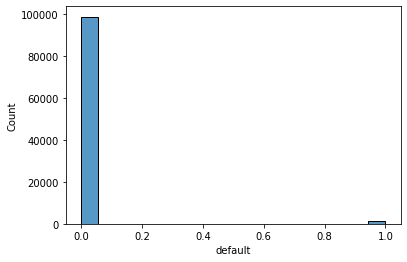

In [61]:
sns.histplot(data=data, x='default')

<AxesSubplot:xlabel='account_worst_status_12_24m', ylabel='Count'>

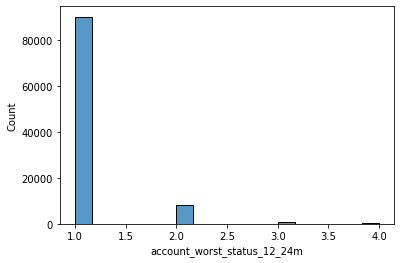

In [62]:
sns.histplot(data=data, x='account_worst_status_12_24m')

## Categorical features  
В данных есть категориальные фичи, посмотрим сколько в каждой из них присутствует категорий.

In [100]:
def get_categories(features: List[str], data: pd.DataFrame) -> None:
    
    for feature in features:
        number_of_categories = data[feature].value_counts().shape[0]
        categories = data[feature].value_counts()
        
        print(f"For <<{feature}>> exists {number_of_categories} categories\n\n"
              f"Top categories:\n________________\n\n{categories[:10]}\n"
             )

In [104]:
cat_features = list(data.select_dtypes(include=['object']).columns)
numeric_features = list(data.drop(columns=['default']).select_dtypes(include=['float', 'int']))

In [105]:
get_categories(cat_features, data)

For <<merchant_category>> exists 57 categories

Top categories:
________________

Diversified entertainment         38614
Youthful Shoes & Clothing         11755
Books & Magazines                  9363
General Shoes & Clothing           4597
Concept stores & Miscellaneous     4406
Sports gear & Outdoor              3712
Dietary supplements                3101
Diversified children products      2994
Diversified electronics            1844
Prints & Photos                    1675
Name: merchant_category, dtype: int64

For <<merchant_group>> exists 12 categories

Top categories:
________________

Entertainment             48779
Clothing & Shoes          16728
Leisure, Sport & Hobby    11025
Health & Beauty            7356
Children Products          5108
Home & Garden              3718
Electronics                3034
Intangible products        1122
Jewelry & Accessories      1058
Automotive Products         937
Name: merchant_group, dtype: int64

For <<name_in_email>> exists 8 categories

T

Во всех категориальных признаках есть одна категория, которая доминирует.  
В фиче "merchant_category" 57 категорий, в "name_in_email" 8, в "merchant_group" 12  
Для простоты будет использоваться LabelEncoder, хотя он и не очень хорошо работает в связке с логистической регрессией

## Label encoding

In [118]:
def encode_categorical(features: List[str], data: pd.DataFrame) -> pd.DataFrame:
    encoded_data = data.copy()
    for feature in features:
        encoder = LabelEncoder()
        encoded_data.loc[:, feature] = encoder.fit_transform(encoded_data.loc[:, feature])
    
    return encoded_data

In [122]:
processed_data = encode_categorical(cat_features, data)
processed_data

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,0.0,0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,20,12.692308,8.333333,15,7,1,31638.0,31638.0,7,0.153846,2,0,0,13,14,0,0.0,0.0,2,1,1,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0.0,0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,50,25.833333,25.000000,4,4,1,13749.0,13749.0,1,0.000000,0,0,0,9,19,3,0.0,0.0,0,1,1,1,1,2,2,0,0,0,49014,13.181389,1.0
2,0.0,0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,22,20.000000,18.000000,22,4,1,29890.0,29890.0,5,0.071429,1,0,0,11,0,3,0.0,0.0,1,1,1,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0.0,0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,36,4.687500,4.888889,22,4,1,40040.0,40040.0,2,0.031250,1,0,0,31,21,0,0.0,0.0,1,1,1,1,1,1,1,0,0,0,324676,15.751111,1.0
4,0.0,0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,25,13.000000,13.000000,25,3,1,7100.0,7100.0,1,0.000000,0,0,0,1,0,0,0.0,0.0,0,1,0,0,1,1,1,0,0,0,7100,12.698611,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99971,0.0,0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,33,10.333333,14.000000,25,3,1,35195.0,35195.0,2,0.000000,0,0,0,6,2,0,0.0,0.0,0,1,1,1,1,1,1,0,0,0,60127,10.765556,1.0
99972,0.0,0,0.0,0.0,0.0,0.004044,1.0,1.0,1.0,1.0,1.0,44,36.000000,14.000000,3,7,1,4740.0,4740.0,2,0.000000,0,0,0,1,3,0,0.0,0.0,1,1,1,1,0,1,1,0,7948,0,4740,21.708333,1.0
99973,0.0,45671,0.0,20.0,0.0,0.705078,2.0,2.0,2.0,1.0,1.0,24,14.000000,14.000000,34,10,1,1200.0,1200.0,6,0.000000,0,0,0,0,0,0,0.0,0.0,18,0,0,0,0,0,0,0,17447,19627,3100,2.185278,1.0
99974,0.0,56102,0.0,0.0,0.0,0.064175,1.0,2.0,1.0,2.0,2.0,31,17.500000,14.000000,14,8,1,15000.0,15000.0,6,0.000000,0,0,0,2,1,0,0.0,0.0,1,1,1,1,1,1,1,0,18339,56180,34785,9.725278,1.0


# Split data to train/test

In [429]:
X, y = processed_data.drop(columns=[TARGET]), processed_data[TARGET]

In [430]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=100,
                                                    stratify=y                                                
                                                   )

Отделим 30% исходных данных в *тестовую выборку*  
Остальные данные будем использовать для обучения

# Logistic Regression

Т.к. данных не очень много и наблюдается сильный дизбаланс, построим сначала логистическую регрессию со сбалансированными весами классов и без параметров  

Сначала обучим несколько моделей, а за тем для всех посчитаем метрики качества

In [262]:
lr_balanced = LogisticRegression(class_weight='balanced')
lr = LogisticRegression()

In [263]:
lr_balanced.fit(X_train, y_train)
lr.fit(X_train, y_train)

/home/ilya/.cache/pypoetry/virtualenvs/otkritie-jtrbvJAy-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ilya/.cache/pypoetry/virtualenvs/otkritie-jtrbvJAy-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

LogisticRegression()

### Resampling

In [269]:
majority_sampler = TomekLinks(sampling_strategy="majority")
X_resempled, y_resempled = majority_sampler.fit_resample(X_train, y_train)
X_resempled

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,39,14.000000,14.0,7,1,0,0.0,0.0,1,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,21.944167,1.0
1,0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,26,22.428571,14.0,22,4,1,11740.0,11740.0,7,0.0,0,0,0,6,10,1,0.0,0.0,0,2,1,1,0,2,2,0,0,0,39300,18.779167,1.0
2,190318,0.0,117.0,0.0,0.538033,1.0,3.0,2.0,2.0,3.0,50,13.400000,12.5,22,4,1,11560.0,11560.0,7,0.0,0,0,0,5,5,0,0.0,0.0,3,1,1,1,1,1,1,0,22386,25885,29789,11.968611,1.0
3,256,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,32,16.111111,14.0,22,4,1,4995.0,9395.0,7,0.0,0,0,0,9,12,0,0.0,0.0,0,1,1,1,1,1,2,0,0,300,27890,22.376667,1.0
4,20537,0.0,0.0,0.0,0.483068,1.0,1.0,1.0,1.0,1.0,31,1.750000,14.0,22,4,1,5495.0,5495.0,2,0.0,0,0,0,4,1,0,0.0,0.0,1,1,1,1,0,1,1,0,14300,5820,13019,20.085833,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69572,0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,25,11.000000,22.0,22,4,1,7773.0,8150.0,5,0.0,0,0,0,4,2,0,0.0,0.0,0,1,1,1,1,1,1,0,0,0,15237,20.705556,1.0
69573,0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,30,10.875000,14.0,22,4,1,3545.0,4776.0,7,0.0,0,0,0,8,9,0,0.0,0.0,0,1,1,1,1,1,1,0,0,0,13260,1.568889,1.0
69574,0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,18,14.000000,14.0,56,2,0,0.0,0.0,5,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,9.082500,1.0
69575,12136,0.0,0.0,0.0,0.088444,1.0,1.0,1.0,1.0,1.0,42,12.000000,14.0,13,9,1,3091.0,3091.0,1,0.0,0,0,0,1,3,0,0.0,0.0,1,1,1,1,0,1,1,0,20537,12168,6181,16.177778,1.0


In [275]:
y_resempled.value_counts()

0.0    68675
1.0      902
Name: default, dtype: int64

In [276]:
lr_with_resample = LogisticRegression()
lr_balanced_with_resample = LogisticRegression(class_weight='balanced')
lr_with_resample.fit(X_resempled, y_resempled)
lr_balanced_with_resample.fit(X_resempled, y_resempled)

/home/ilya/.cache/pypoetry/virtualenvs/otkritie-jtrbvJAy-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ilya/.cache/pypoetry/virtualenvs/otkritie-jtrbvJAy-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

LogisticRegression(class_weight='balanced')

In [277]:
X_positive = X_train.loc[y_train == 1]
y_positive = y_train[y_train == 1]
X_negative_random = X_train.loc[y_train == 0].sample(n=X_positive.shape[0], random_state=100)
negative_index = X_negative_random.index
y_negative_random = y_train[negative_index]

X_random_sample = pd.concat([X_positive, X_negative_random], axis=0, ignore_index=True)
y_random_sample = pd.concat([y_positive, y_negative_random], axis=0, ignore_index=True)
X_random_sample = X_random_sample.sample(frac=1, random_state=100)
y_random_sample = y_random_sample.sample(frac=1, random_state=100)

Не делаем здесь class_weight='balanced', т.к. классы и так сбалансированы

In [278]:
lr_random = LogisticRegression()
lr_random.fit(X_random_sample, y_random_sample)

/home/ilya/.cache/pypoetry/virtualenvs/otkritie-jtrbvJAy-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [279]:
resampler_nm = NearMiss()
X_nm, y_nm = resampler_nm.fit_resample(X_train, y_train)

In [283]:
lr_nearmiss = LogisticRegression()
lr_nearmiss.fit(X_nm, y_nm)

/home/ilya/.cache/pypoetry/virtualenvs/otkritie-jtrbvJAy-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Catboost model

Построим так же CatBoostClassifier

*best_params* подобраны при помощи библиотеки Optuna, подбор гиперпараметров в конце ноутбука, здесь используем сразу лучшие параметры

In [450]:
best_params = {'max_depth': 10,
               'learning_rate': 0.0914524764476857,
               'n_estimators': 869,
               'max_bin': 328,
               'min_data_in_leaf': 225,
               'l2_leaf_reg': 0.00018343316794138166,
               'subsample': 0.7998316211585444,
               'loss_function': 'CrossEntropy',
               'eval_metric': 'F1',
               'task_type': 'CPU',
               'use_best_model': True,
               'early_stopping_rounds': 150,
               'verbose': 100}

catboost = CatBoostClassifier(**best_params, cat_features=cat_features)
catboost_resampled = CatBoostClassifier(**best_params, cat_features=cat_features)
catboost_random = CatBoostClassifier(**best_params, cat_features=cat_features)
catboost_nm = CatBoostClassifier(**best_params, cat_features=cat_features)

In [451]:
X_train_ctb, X_val, y_train_ctb, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=1000)
catboost.fit(X_train_ctb, y_train_ctb, eval_set=(X_val, y_val))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 123ms	remaining: 1m 47s


Training has stopped (degenerate solution on iteration 40, probably too small l2-regularization, try to increase it)



bestTest = 0.03603603604
bestIteration = 26

Shrink model to first 27 iterations.


In [452]:
X_train, X_val, y_train, y_val = train_test_split(X_resempled,
                                                    y_resempled,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=1000)
catboost_resampled.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 0.0265700	test: 0.0000000	best: 0.0000000 (0)	total: 105ms	remaining: 1m 31s

bestTest = 0.06382978723
bestIteration = 33

Shrink model to first 34 iterations.


Training has stopped (degenerate solution on iteration 39, probably too small l2-regularization, try to increase it)


In [453]:
X_train_rnd, X_val_rnd, y_train_rnd, y_val_rnd = train_test_split(X_random_sample,
                                                    y_random_sample,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=1000)
catboost_random.fit(X_train_rnd, y_train_rnd, eval_set=(X_val_rnd, y_val_rnd))

0:	learn: 0.8207493	test: 0.7322404	best: 0.7322404 (0)	total: 50.3ms	remaining: 43.7s
100:	learn: 1.0000000	test: 0.7675676	best: 0.7849462 (79)	total: 2.7s	remaining: 20.5s
200:	learn: 1.0000000	test: 0.7734807	best: 0.7849462 (79)	total: 5.72s	remaining: 19s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7849462366
bestIteration = 79

Shrink model to first 80 iterations.


In [454]:
X_train, X_val, y_train, y_val = train_test_split(X_nm,
                                                    y_nm,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=1000)
catboost_nm.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 0.9053607	test: 0.9162562	best: 0.9162562 (0)	total: 40.2ms	remaining: 34.9s
100:	learn: 0.9833972	test: 0.9708738	best: 0.9708738 (47)	total: 2.31s	remaining: 17.6s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9708737864
bestIteration = 47

Shrink model to first 48 iterations.


## Models evaluation

In [455]:
def compute_metrics(metrics_scored: Dict[str, Callable], metrics_labeled: Dict[str, Callable],
                    y_true: pd.Series, X_test: pd.DataFrame, models: Dict[str, BaseEstimator]) -> pd.DataFrame:
    
    metrics_df = pd.DataFrame()
    
    for model_name, model in models.items():
        current_metrics = pd.DataFrame()
        current_metrics.loc[0, 'model_name'] = model_name
            
        scores = model.predict_proba(X_test)[:, 1]
        labels = model.predict(X_test)
    
        for name, metric in metrics_scored.items():
            current_metrics.loc[0, name] = metric(y_true, scores)

        for name, metric in metrics_labeled.items():
            current_metrics.loc[0, name] = metric(y_true, labels)
        
        metrics_df = pd.concat([metrics_df, current_metrics], axis=0, ignore_index=True)
    
    return metrics_df  

In [456]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_confusion_matrix(model, name: str, X_test: pd.DataFrame, y_test: pd.Series) -> None:
    labels = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, labels)

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.5g')

    ax.set_title(f'{name}\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

Посчитаем все метрики, которые могут оказаться полезными

In [457]:
METRICS_SCORED = {'ROC AUC': roc_auc_score,
                  'Average Precision': average_precision_score,
                 }

METRICS_LABELED = {'Balanced Accuracy': balanced_accuracy_score,
                   'F1': f1_score,
                   'MCC': matthews_corrcoef,
                   'Kappa': cohen_kappa_score,
                   'Precision': precision_score,
                   'Recall': recall_score
                  }

In [458]:
models_zoo = {'lr': lr,
              'lr_balanced': lr_balanced,
              'lr_resample': lr_with_resample,
              'lr_balanced_resample': lr_balanced_with_resample,
              'lr_random': lr_random,
              'lr_nearmiss': lr_nearmiss,
              'catboost': catboost,
              'catboost_resampled': catboost_resampled,
              'catboost_random': catboost_random,
              'catboost_nm': catboost_nm,
             }

In [459]:
metrics_df = pd.DataFrame()
metrics_df = compute_metrics(METRICS_SCORED, METRICS_LABELED, y_test, X_test, models_zoo)
metrics_df

,model_name,ROC AUC,Average Precision,Balanced Accuracy,F1,MCC,Kappa,Precision,Recall
0,lr,0.631552,0.023437,0.499966,0.000000,-0.000932,-0.000133,0.000000,0.000000
1,lr_balanced,0.826005,0.064806,0.740682,0.072823,0.127064,0.049606,0.038365,0.715026
2,lr_resample,0.624374,0.022825,0.499966,0.000000,-0.000932,-0.000133,0.000000,0.000000
3,lr_balanced_resample,0.826106,0.064199,0.748254,0.064997,0.122116,0.041337,0.033893,0.790155
4,lr_random,0.822199,0.065218,0.741187,0.063728,0.118527,0.040032,0.033226,0.777202
5,lr_nearmiss,0.449191,0.011528,0.479501,0.024249,-0.016015,-0.001160,0.012296,0.867876
6,catboost,0.877310,0.139426,0.504996,0.019950,0.050369,0.019006,0.266667,0.010363
7,catboost_resampled,0.881216,0.134818,0.511337,0.043478,0.083683,0.041810,0.321429,0.023316
8,catboost_random,0.879153,0.093048,0.804575,0.081492,0.156765,0.058404,0.042772,0.860104
9,catboost_nm,0.516069,0.015129,0.475682,0.024116,-0.025684,-0.001314,0.012221,0.904145


По значениям метрик не совсем понятно, какая из моделей лучше, построим confusion матрицы для каждой модели  
Будем обращать внимание на TP, FP и FN, т.к. они встречаются в формулах Precision/Recall/F1  

На графиках значения расположены в таком порядке:
| TN | FP |
|----|----|
| __FN__ | __TP__ |

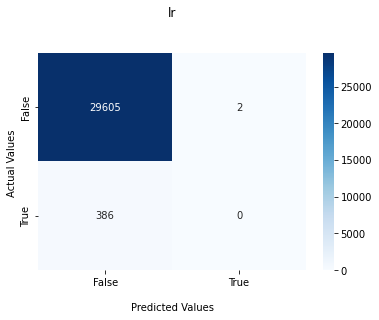

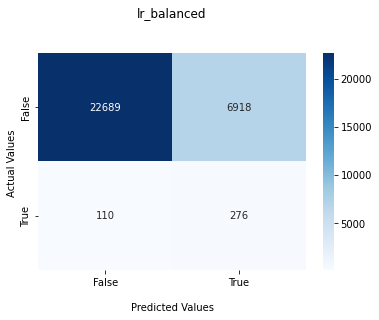

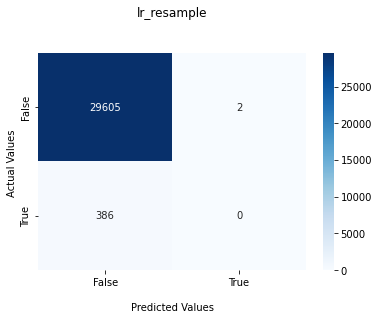

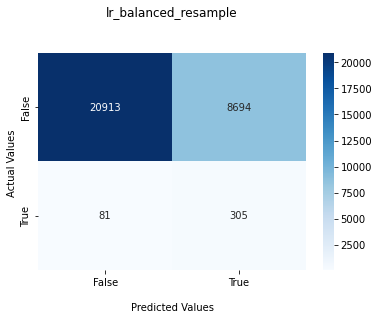

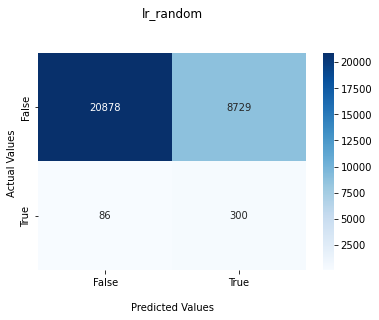

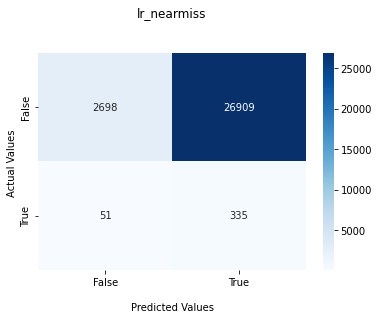

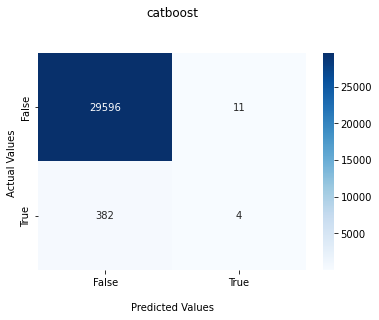

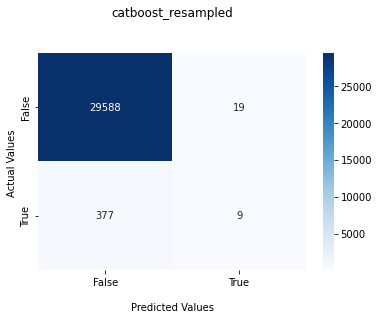

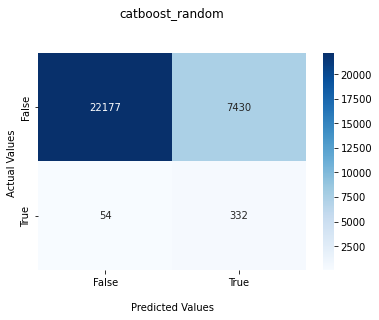

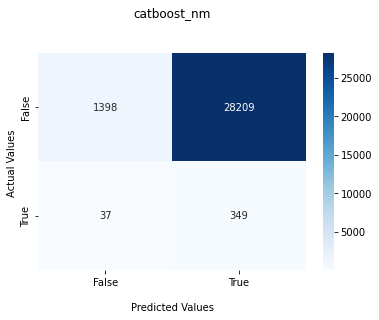

In [460]:
for name, model in models_zoo.items():
    show_confusion_matrix(model, name, X_test, y_test)

Для задачи определения дефолта наиболее важно найти все "единички" наиболее точно, чтобы не потерять деньги, можно допустить ложные срабатывания __FP__

Наиболее хорошо с этим справились модели *catboost_random* и *lr_random*

# Feature importance

Здесь можно попытаться интерпретировать, какие фичи наиболее важны для определения дефолта

In [371]:
feature_importances = pd.DataFrame({'feature':X_train.columns, 'importance':catboost.get_feature_importance()})
feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index()
feature_importances = feature_importances.drop(columns=['index'])
feature_importances.head(10)

,feature,importance
0,status_max_archived_0_24_months,26.871998
1,merchant_group,14.845887
2,has_paid,13.743412
3,merchant_category,7.788593
4,account_incoming_debt_vs_paid_0_24m,5.452992
5,sum_capital_paid_account_0_12m,4.391067
6,status_2nd_last_archived_0_24m,4.188506
7,age,3.115478
8,max_paid_inv_0_24m,2.851652
9,sum_paid_inv_0_12m,2.849254


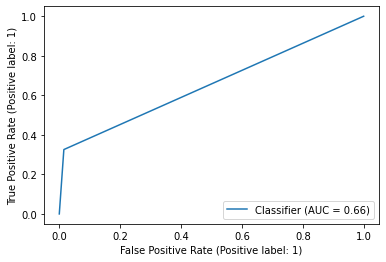

In [124]:
RocCurveDisplay.from_predictions(y_test, (scores > best_cutoff).astype(int))

# Cross validation StratifiedKFold

In [499]:
def fit_predict_cv(X, y, target: str, params: Dict, n_splits: int = 5, cutoff: float = 0.5):
        
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.25,
                                                        shuffle=True,
                                                        random_state=100,
                                                        stratify=y                                                
                                                       )
    
    test_preds = np.zeros(X_test.shape[0])
    val_preds = np.zeros(X_train.shape[0])
    print(f"SHAPE TEST_PREDS {X_test.shape[0]}")
    print(f"SHAPE VAL_PREDS {X_train.shape[0]}")

    
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folder.split(X_train, y_train)):
            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
            
            catboost_clf = CatBoostClassifier(**best_params)
            
            train_pool = Pool(train_x, train_y, cat_features=cat_features)
            val_pool = Pool(valid_x, valid_y, cat_features=cat_features)
            
            catboost_clf.fit(train_pool, eval_set=val_pool)
            
            test_preds += catboost_clf.predict_proba(X_test)[:, 1]
            val_preds[valid_idx] = catboost_clf.predict_proba(valid_x)[:, 1]
                        
            print(f"Fold #{n_fold + 1} ROC AUC score: {np.round(roc_auc_score(valid_y, val_preds[valid_idx]), 2)}")
        
            del catboost_clf, train_x, train_y, valid_x, valid_y

    test_preds = test_preds / n_splits
    test_labels = [1 if score > cutoff else 0 for score in test_preds]
    print(f"Test ROC AUC score: {np.round(roc_auc_score(y_test, test_preds), 2)}")
    print(f"Test Precision score: {np.round(precision_score(y_test, test_labels), 2)}")
    print(f"Test Recall score: {np.round(recall_score(y_test, test_labels), 2)}")

    
    return test_preds, X_test, y_test

In [500]:
X, y = processed_data.drop(columns=[TARGET]), processed_data[TARGET]

In [501]:
cv_scores, X_test, y_test = fit_predict_cv(X, y, TARGET, best_params, cutoff=optimal_cutoff[0])

SHAPE TEST_PREDS 24994
SHAPE VAL_PREDS 74982
0:	learn: 0.0025840	test: 0.0103093	best: 0.0103093 (0)	total: 85.2ms	remaining: 1m 13s
100:	learn: 0.6842553	test: 0.1009174	best: 0.1111111 (66)	total: 9.29s	remaining: 1m 10s
200:	learn: 0.8584071	test: 0.0900901	best: 0.1111111 (66)	total: 18.4s	remaining: 1m 1s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.1111111111
bestIteration = 66

Shrink model to first 67 iterations.
Fold #1 ROC AUC score: 0.84
0:	learn: 0.0179028	test: 0.0102564	best: 0.0102564 (0)	total: 81.1ms	remaining: 1m 10s
100:	learn: 0.7141674	test: 0.0711111	best: 0.0711111 (93)	total: 8.69s	remaining: 1m 6s
200:	learn: 0.8571429	test: 0.0900901	best: 0.0973451 (126)	total: 17.8s	remaining: 59.2s
300:	learn: 0.9222222	test: 0.1043478	best: 0.1071429 (249)	total: 27.5s	remaining: 51.8s


Training has stopped (degenerate solution on iteration 373, probably too small l2-regularization, try to increase it)



bestTest = 0.1071428571
bestIteration = 249

Shrink model to first 250 iterations.
Fold #2 ROC AUC score: 0.77
0:	learn: 0.0128535	test: 0.0000000	best: 0.0000000 (0)	total: 99.5ms	remaining: 1m 26s
100:	learn: 0.7142857	test: 0.0837209	best: 0.0938967 (65)	total: 8.75s	remaining: 1m 6s
200:	learn: 0.8741818	test: 0.1198157	best: 0.1198157 (195)	total: 17.9s	remaining: 59.5s
300:	learn: 0.9482993	test: 0.0761905	best: 0.1198157 (195)	total: 27.5s	remaining: 51.8s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.1198156682
bestIteration = 195

Shrink model to first 196 iterations.
Fold #3 ROC AUC score: 0.75
0:	learn: 0.0128535	test: 0.0000000	best: 0.0000000 (0)	total: 114ms	remaining: 1m 39s
100:	learn: 0.7191384	test: 0.0769231	best: 0.0865385 (90)	total: 8.72s	remaining: 1m 6s


Training has stopped (degenerate solution on iteration 174, probably too small l2-regularization, try to increase it)



bestTest = 0.09523809524
bestIteration = 170

Shrink model to first 171 iterations.
Fold #4 ROC AUC score: 0.77
0:	learn: 0.0154044	test: 0.0000000	best: 0.0000000 (0)	total: 100ms	remaining: 1m 26s
100:	learn: 0.7051926	test: 0.0579710	best: 0.0579710 (94)	total: 8.74s	remaining: 1m 6s
200:	learn: 0.8893678	test: 0.0574163	best: 0.0579710 (94)	total: 17.8s	remaining: 59s
300:	learn: 0.9624161	test: 0.0483092	best: 0.0582524 (235)	total: 27.5s	remaining: 51.9s


Training has stopped (degenerate solution on iteration 318, probably too small l2-regularization, try to increase it)



bestTest = 0.05825242718
bestIteration = 235

Shrink model to first 236 iterations.
Fold #5 ROC AUC score: 0.79
Test ROC AUC score: 0.87
Test Precision score: 0.05
Test Recall score: 0.79


# Choose best cutoff

Для улучшения точности можно попробовать изменить порог бинаризации

In [502]:
from sklearn.metrics import roc_curve

def find_optimal_cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    # sns.lineplot(fpr, threshold)
    # sns.lineplot(tpr, threshold)

    return list(roc_t['threshold']) 

In [503]:
optimal_cutoff_cv = find_optimal_cutoff(y_test, cv_scores)
optimal_cutoff_cv

[0.006071867154991063]

In [543]:
def show_confusion_matrix_(y_test, y_pred, cutoff, name):
    
    cf_matrix = confusion_matrix(y_test, (y_pred > cutoff).astype(int))

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.5g')

    ax.set_title(f'{name}\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

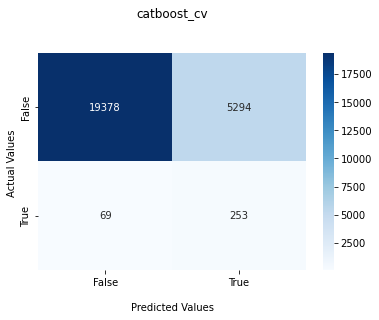

In [544]:
show_confusion_matrix_(y_test, cv_scores, optimal_cutoff_cv, 'catboost_cv')

[0.7149468922472766]


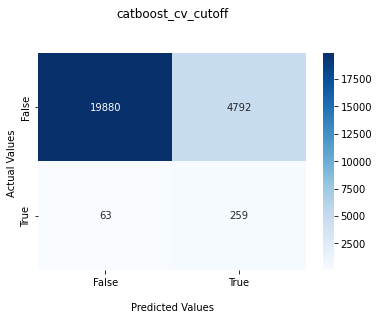

In [545]:
scores_ctb_random = catboost_random.predict_proba(X_test)[:, 1]
optimal_cutoff_ctb = find_optimal_cutoff(y_test, scores_ctb_random)
print(optimal_cutoff_ctb)
show_confusion_matrix_(y_test, scores_ctb_random, optimal_cutoff_ctb, 'catboost_cv_cutoff')

# Results

In [539]:
class catboost_cv:
    def __init__(self, cv_scores, cutoff):
        self.cv_scores = cv_scores
        self.cutoff = cutoff
    
    def predict(self, X_test):
        return (self.cv_scores > self.cutoff).astype(int)
    
    def predict_proba(self, X_test):
        return np.array([self.cv_scores, self.cv_scores]).reshape(self.cv_scores.shape[0], 2)

catboost_cv_model = catboost_cv(cv_scores, optimal_cutoff_cv)

In [540]:
models_zoo = {'lr': lr,
              'lr_balanced': lr_balanced,
              'lr_resample': lr_with_resample,
              'lr_balanced_resample': lr_balanced_with_resample,
              'lr_random': lr_random,
              'lr_nearmiss': lr_nearmiss,
              'catboost': catboost,
              'catboost_resampled': catboost_resampled,
              'catboost_random': catboost_random,
              'catboost_nm': catboost_nm,
              'catboost_cv': catboost_cv_model 
             }

In [541]:
metrics_df = pd.DataFrame()
metrics_df = compute_metrics(METRICS_SCORED, METRICS_LABELED, y_test, X_test, models_zoo)
metrics_df

,model_name,ROC AUC,Average Precision,Balanced Accuracy,F1,MCC,Kappa,Precision,Recall
0,lr,0.636796,0.024156,0.499959,0.000000,-0.001022,-0.000159,0.000000,0.000000
1,lr_balanced,0.822580,0.065545,0.733308,0.071159,0.122989,0.047870,0.037479,0.701863
2,lr_resample,0.629938,0.023549,0.499959,0.000000,-0.001022,-0.000159,0.000000,0.000000
3,lr_balanced_resample,0.821527,0.064185,0.743748,0.064163,0.119807,0.040453,0.033453,0.782609
4,lr_random,0.819823,0.066388,0.737314,0.063088,0.116614,0.039350,0.032891,0.770186
5,lr_nearmiss,0.455279,0.011688,0.480847,0.024347,-0.014901,-0.001086,0.012346,0.869565
6,catboost,0.871877,0.140518,0.504435,0.017857,0.042280,0.016802,0.214286,0.009317
7,catboost_resampled,0.876815,0.135656,0.510525,0.040462,0.076642,0.038744,0.291667,0.021739
8,catboost_random,0.879727,0.095832,0.808445,0.081919,0.158476,0.058811,0.042984,0.869565
9,catboost_nm,0.519853,0.015516,0.480517,0.024394,-0.020457,-0.001054,0.012362,0.913043


Наилучший результат показала модель __catboost_random__ со значениями метрик:  
   + __Precision__ = 0.042
   + __Recall__ = 0.87

# Optuna hyperparameters optimizing

Здесь потюним параметры катбуста

In [446]:
def objective(trial, X_train=X_train_rnd, y_train=y_train_rnd, X_val=X_val_rnd, y_val=y_val_rnd, cat_features=cat_features):
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'random_seed': 42,
        'task_type': 'CPU',
        'loss_function': trial.suggest_categorical('loss_function', ['CrossEntropy', 'Logloss']),
        'eval_metric': trial.suggest_categorical('eval_metric', ["MCC", "F1", "BalancedAccuracy"]),
        'use_best_model':True
        # 'bootstrap_type': 'Poisson'
    }
    
    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
    
    model = CatBoostClassifier(**params)  
    model.fit(train_pool,
              eval_set=eval_pool,
              early_stopping_rounds=150,
              verbose=50)
    y_pred = model.predict_proba(X_val)[:,1]
    y_labels = model.predict(X_val)
    metric = f1_score(y_val, y_labels)

    return metric

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
print('Best value:', study.best_value)

[I 2022-05-27 23:17:47,765] A new study created in memory with name: no-name-af9b0618-4908-41bd-86b6-313c3a786f52


0:	learn: 0.7010090	test: 0.3081764	best: 0.3081764 (0)	total: 321ms	remaining: 4m 6s
50:	learn: 1.0000000	test: 0.5828249	best: 0.5828249 (50)	total: 14.2s	remaining: 3m 20s
100:	learn: 1.0000000	test: 0.5648763	best: 0.6021159 (52)	total: 27.3s	remaining: 3m
150:	learn: 1.0000000	test: 0.5626617	best: 0.6021159 (52)	total: 40.5s	remaining: 2m 45s
200:	learn: 1.0000000	test: 0.5626617	best: 0.6021159 (52)	total: 53.5s	remaining: 2m 31s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6021158648
bestIteration = 52

Shrink model to first 53 iterations.


[I 2022-05-27 23:18:42,586] Trial 0 finished with value: 0.7978142076502732 and parameters: {'max_depth': 13, 'learning_rate': 0.1849024354521208, 'n_estimators': 770, 'max_bin': 392, 'min_data_in_leaf': 189, 'l2_leaf_reg': 0.24346289273458263, 'subsample': 0.6544406848204968, 'loss_function': 'Logloss', 'eval_metric': 'MCC'}. Best is trial 0 with value: 0.7978142076502732.


0:	learn: 0.7613527	test: 0.7043478	best: 0.7043478 (0)	total: 5.53ms	remaining: 5.42s
50:	learn: 0.8678802	test: 0.7567568	best: 0.7675676 (43)	total: 139ms	remaining: 2.54s
100:	learn: 0.8996416	test: 0.7650273	best: 0.7849462 (62)	total: 202ms	remaining: 1.76s
150:	learn: 0.9171139	test: 0.7734807	best: 0.7849462 (62)	total: 275ms	remaining: 1.51s
200:	learn: 0.9354255	test: 0.7759563	best: 0.7849462 (62)	total: 344ms	remaining: 1.34s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7849462366
bestIteration = 62

Shrink model to first 63 iterations.


[I 2022-05-27 23:18:43,155] Trial 1 finished with value: 0.7849462365591398 and parameters: {'max_depth': 4, 'learning_rate': 0.16163576516659117, 'n_estimators': 983, 'max_bin': 335, 'min_data_in_leaf': 96, 'l2_leaf_reg': 0.00363932853600015, 'subsample': 0.2352033896692348, 'loss_function': 'Logloss', 'eval_metric': 'F1'}. Best is trial 0 with value: 0.7978142076502732.


0:	learn: 0.7668030	test: 0.7058824	best: 0.7058824 (0)	total: 4.9ms	remaining: 4.64s
50:	learn: 0.8490128	test: 0.7634409	best: 0.7741935 (25)	total: 145ms	remaining: 2.56s
100:	learn: 0.8810939	test: 0.7765957	best: 0.7807487 (68)	total: 199ms	remaining: 1.66s
150:	learn: 0.8988095	test: 0.7853403	best: 0.7916667 (128)	total: 252ms	remaining: 1.33s
200:	learn: 0.9114833	test: 0.7748691	best: 0.7916667 (128)	total: 307ms	remaining: 1.14s
250:	learn: 0.9231693	test: 0.7748691	best: 0.7916667 (128)	total: 363ms	remaining: 1.01s
300:	learn: 0.9356584	test: 0.7807487	best: 0.7936508 (255)	total: 421ms	remaining: 905ms
350:	learn: 0.9431681	test: 0.7830688	best: 0.7978723 (333)	total: 479ms	remaining: 814ms
400:	learn: 0.9510574	test: 0.7765957	best: 0.7978723 (333)	total: 535ms	remaining: 730ms
450:	learn: 0.9564165	test: 0.7634409	best: 0.7978723 (333)	total: 591ms	remaining: 652ms
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7978723404
bestIteration = 333

Shrink

[I 2022-05-27 23:18:44,001] Trial 2 finished with value: 0.7978723404255319 and parameters: {'max_depth': 3, 'learning_rate': 0.15457860448687372, 'n_estimators': 948, 'max_bin': 253, 'min_data_in_leaf': 133, 'l2_leaf_reg': 0.00042611976016505496, 'subsample': 0.5626970602120783, 'loss_function': 'Logloss', 'eval_metric': 'F1'}. Best is trial 2 with value: 0.7978723404255319.


0:	learn: 0.8763636	test: 0.6040268	best: 0.6040268 (0)	total: 1.01s	remaining: 13m 48s
50:	learn: 1.0000000	test: 0.7666667	best: 0.7978142 (34)	total: 38.5s	remaining: 9m 42s
100:	learn: 1.0000000	test: 0.7802198	best: 0.7978142 (34)	total: 1m 22s	remaining: 9m 52s
150:	learn: 1.0000000	test: 0.7912088	best: 0.7978142 (34)	total: 2m 7s	remaining: 9m 25s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7978142077
bestIteration = 34

Shrink model to first 35 iterations.


[I 2022-05-27 23:21:23,278] Trial 3 finished with value: 0.7978142076502732 and parameters: {'max_depth': 15, 'learning_rate': 0.1779675319273212, 'n_estimators': 823, 'max_bin': 292, 'min_data_in_leaf': 45, 'l2_leaf_reg': 0.0861165068203147, 'subsample': 0.3817901258482904, 'loss_function': 'Logloss', 'eval_metric': 'F1'}. Best is trial 2 with value: 0.7978723404255319.


0:	learn: 0.8383501	test: 0.6444444	best: 0.6444444 (0)	total: 35.2ms	remaining: 30.6s
50:	learn: 0.9932639	test: 0.8021390	best: 0.8021390 (50)	total: 1.31s	remaining: 21s
100:	learn: 1.0000000	test: 0.8043478	best: 0.8342246 (58)	total: 2.63s	remaining: 20s
150:	learn: 1.0000000	test: 0.7868852	best: 0.8342246 (58)	total: 3.99s	remaining: 19s
200:	learn: 1.0000000	test: 0.7955801	best: 0.8342246 (58)	total: 5.32s	remaining: 17.7s


[I 2022-05-27 23:21:29,027] Trial 4 finished with value: 0.8342245989304814 and parameters: {'max_depth': 10, 'learning_rate': 0.0914524764476857, 'n_estimators': 869, 'max_bin': 328, 'min_data_in_leaf': 225, 'l2_leaf_reg': 0.00018343316794138166, 'subsample': 0.7998316211585444, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8342245989
bestIteration = 58

Shrink model to first 59 iterations.
0:	learn: 0.7559113	test: 0.6732327	best: 0.6732327 (0)	total: 9.69ms	remaining: 5.75s
50:	learn: 0.8894220	test: 0.8005032	best: 0.8005032 (50)	total: 250ms	remaining: 2.66s
100:	learn: 0.9370507	test: 0.8227172	best: 0.8227172 (78)	total: 458ms	remaining: 2.24s
150:	learn: 0.9685401	test: 0.8064556	best: 0.8286696 (101)	total: 659ms	remaining: 1.94s
200:	learn: 0.9846201	test: 0.8124080	best: 0.8286696 (101)	total: 863ms	remaining: 1.69s


[I 2022-05-27 23:21:30,317] Trial 5 finished with value: 0.8260869565217391 and parameters: {'max_depth': 7, 'learning_rate': 0.05836082220423096, 'n_estimators': 595, 'max_bin': 296, 'min_data_in_leaf': 30, 'l2_leaf_reg': 0.011552624528883768, 'subsample': 0.15900328795500002, 'loss_function': 'Logloss', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


250:	learn: 0.9932269	test: 0.7878007	best: 0.8286696 (101)	total: 1.07s	remaining: 1.46s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8286696122
bestIteration = 101

Shrink model to first 102 iterations.
0:	learn: 0.8297501	test: 0.6395349	best: 0.6395349 (0)	total: 73.7ms	remaining: 1m 10s
50:	learn: 0.9993891	test: 0.7734807	best: 0.7845304 (19)	total: 2.31s	remaining: 40.8s
100:	learn: 1.0000000	test: 0.7802198	best: 0.7912088 (90)	total: 4.64s	remaining: 39.1s
150:	learn: 1.0000000	test: 0.7783784	best: 0.7912088 (90)	total: 6.98s	remaining: 37s
200:	learn: 1.0000000	test: 0.7826087	best: 0.7912088 (90)	total: 9.3s	remaining: 34.7s


[I 2022-05-27 23:21:41,703] Trial 6 finished with value: 0.7912087912087913 and parameters: {'max_depth': 11, 'learning_rate': 0.175884271665858, 'n_estimators': 951, 'max_bin': 274, 'min_data_in_leaf': 132, 'l2_leaf_reg': 0.3408794516483837, 'subsample': 0.18907332403760763, 'loss_function': 'Logloss', 'eval_metric': 'F1'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7912087912
bestIteration = 90

Shrink model to first 91 iterations.
0:	learn: 0.8441100	test: 0.6402185	best: 0.6402185 (0)	total: 410ms	remaining: 6m 6s
50:	learn: 1.0000000	test: 0.7203608	best: 0.7552774 (9)	total: 18.7s	remaining: 5m 9s
100:	learn: 1.0000000	test: 0.7485272	best: 0.7552774 (9)	total: 38.5s	remaining: 5m 2s
150:	learn: 1.0000000	test: 0.7485272	best: 0.7552774 (9)	total: 58s	remaining: 4m 45s


[I 2022-05-27 23:22:43,437] Trial 7 finished with value: 0.7513812154696132 and parameters: {'max_depth': 14, 'learning_rate': 0.18370797107408277, 'n_estimators': 895, 'max_bin': 252, 'min_data_in_leaf': 45, 'l2_leaf_reg': 0.06490803506933208, 'subsample': 0.7207010179140392, 'loss_function': 'Logloss', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7552773687
bestIteration = 9

Shrink model to first 10 iterations.
0:	learn: 0.6824399	test: 0.3686151	best: 0.3686151 (0)	total: 224ms	remaining: 2m 34s
50:	learn: 0.9987684	test: 0.5509156	best: 0.5732533 (13)	total: 9.7s	remaining: 2m 2s
100:	learn: 1.0000000	test: 0.5701650	best: 0.5828249 (80)	total: 18.8s	remaining: 1m 50s
150:	learn: 1.0000000	test: 0.6147245	best: 0.6147245 (147)	total: 28.5s	remaining: 1m 42s
200:	learn: 1.0000000	test: 0.6051323	best: 0.6147245 (147)	total: 38.3s	remaining: 1m 33s
250:	learn: 1.0000000	test: 0.6021159	best: 0.6147245 (147)	total: 48.1s	remaining: 1m 24s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6147244944
bestIteration = 147

Shrink model to first 148 iterations.


[I 2022-05-27 23:23:41,075] Trial 8 finished with value: 0.8043478260869565 and parameters: {'max_depth': 13, 'learning_rate': 0.06368940642839768, 'n_estimators': 693, 'max_bin': 272, 'min_data_in_leaf': 300, 'l2_leaf_reg': 0.03825344580807448, 'subsample': 0.19929361108556454, 'loss_function': 'CrossEntropy', 'eval_metric': 'MCC'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.6160364	test: 0.3581934	best: 0.3581934 (0)	total: 11.7ms	remaining: 6.82s
50:	learn: 0.9017821	test: 0.5413557	best: 0.5732533 (16)	total: 652ms	remaining: 6.84s
100:	learn: 0.9950705	test: 0.5637268	best: 0.5766495 (57)	total: 1.31s	remaining: 6.3s
150:	learn: 1.0000000	test: 0.5605176	best: 0.5860978 (118)	total: 1.97s	remaining: 5.67s
200:	learn: 1.0000000	test: 0.5637268	best: 0.5860978 (118)	total: 2.62s	remaining: 5.03s
250:	learn: 1.0000000	test: 0.5701650	best: 0.5924447 (207)	total: 3.27s	remaining: 4.37s
300:	learn: 1.0000000	test: 0.5605176	best: 0.5924447 (207)	total: 3.93s	remaining: 3.72s
350:	learn: 1.0000000	test: 0.5605176	best: 0.5924447 (207)	total: 4.59s	remaining: 3.07s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.592444732
bestIteration = 207

Shrink model to first 208 iterations.


[I 2022-05-27 23:23:45,996] Trial 9 finished with value: 0.7934782608695652 and parameters: {'max_depth': 9, 'learning_rate': 0.09568126167114296, 'n_estimators': 586, 'max_bin': 213, 'min_data_in_leaf': 5, 'l2_leaf_reg': 0.3337243088231251, 'subsample': 0.5627530242232511, 'loss_function': 'CrossEntropy', 'eval_metric': 'MCC'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.8205980	test: 0.7150259	best: 0.7150259 (0)	total: 11ms	remaining: 9.24s
50:	learn: 0.8811594	test: 0.7567568	best: 0.7717391 (8)	total: 247ms	remaining: 3.83s
100:	learn: 0.8968347	test: 0.7741935	best: 0.7741935 (60)	total: 464ms	remaining: 3.41s
150:	learn: 0.9163205	test: 0.7807487	best: 0.7849462 (114)	total: 686ms	remaining: 3.15s
200:	learn: 0.9331728	test: 0.7807487	best: 0.7849462 (114)	total: 913ms	remaining: 2.92s
250:	learn: 0.9496053	test: 0.7914439	best: 0.7956989 (215)	total: 1.15s	remaining: 2.71s
300:	learn: 0.9600484	test: 0.7934783	best: 0.7956989 (215)	total: 1.36s	remaining: 2.46s
350:	learn: 0.9708384	test: 0.7934783	best: 0.7978142 (335)	total: 1.59s	remaining: 2.23s
400:	learn: 0.9798412	test: 0.7891892	best: 0.8087432 (368)	total: 1.82s	remaining: 2.01s
450:	learn: 0.9926918	test: 0.7868852	best: 0.8087432 (368)	total: 2.05s	remaining: 1.78s
500:	learn: 0.9975610	test: 0.7868852	best: 0.8087432 (368)	total: 2.28s	remaining: 1.56s
Stopped by overfitt

[I 2022-05-27 23:23:48,854] Trial 10 finished with value: 0.8087431693989071 and parameters: {'max_depth': 7, 'learning_rate': 0.01956676386509336, 'n_estimators': 843, 'max_bin': 344, 'min_data_in_leaf': 245, 'l2_leaf_reg': 0.00010429666186570949, 'subsample': 0.7884117172508848, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7947562	test: 0.7088856	best: 0.7088856 (0)	total: 7.83ms	remaining: 4.26s
50:	learn: 0.9048315	test: 0.7798846	best: 0.7858370 (40)	total: 251ms	remaining: 2.43s
100:	learn: 0.9395154	test: 0.7790869	best: 0.7901939 (55)	total: 460ms	remaining: 2.02s
150:	learn: 0.9796512	test: 0.7834438	best: 0.7901939 (55)	total: 675ms	remaining: 1.76s


[I 2022-05-27 23:23:50,040] Trial 11 finished with value: 0.7891891891891892 and parameters: {'max_depth': 7, 'learning_rate': 0.0706101123076901, 'n_estimators': 545, 'max_bin': 329, 'min_data_in_leaf': 203, 'l2_leaf_reg': 0.005951518057022013, 'subsample': 0.3676417911525557, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


200:	learn: 0.9963029	test: 0.7620275	best: 0.7901939 (55)	total: 892ms	remaining: 1.53s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7901939126
bestIteration = 55

Shrink model to first 56 iterations.
0:	learn: 0.7702858	test: 0.7136721	best: 0.7136721 (0)	total: 28.2ms	remaining: 19.1s
50:	learn: 0.9932368	test: 0.7671821	best: 0.7961463 (9)	total: 1.01s	remaining: 12.5s
100:	learn: 1.0000000	test: 0.7671821	best: 0.7961463 (9)	total: 1.96s	remaining: 11.3s
150:	learn: 1.0000000	test: 0.7620275	best: 0.7961463 (9)	total: 2.93s	remaining: 10.3s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7961462936
bestIteration = 9

Shrink model to first 10 iterations.


[I 2022-05-27 23:23:53,404] Trial 12 finished with value: 0.7956989247311828 and parameters: {'max_depth': 9, 'learning_rate': 0.12252074618876342, 'n_estimators': 680, 'max_bin': 373, 'min_data_in_leaf': 250, 'l2_leaf_reg': 0.001325387045717605, 'subsample': 0.10478251317349967, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7836748	test: 0.7080879	best: 0.7080879 (0)	total: 5.41ms	remaining: 3.4s
50:	learn: 0.8546394	test: 0.7747300	best: 0.7747300 (44)	total: 176ms	remaining: 2s
100:	learn: 0.8837727	test: 0.7798846	best: 0.7858370 (97)	total: 302ms	remaining: 1.58s
150:	learn: 0.8986697	test: 0.7798846	best: 0.7858370 (97)	total: 428ms	remaining: 1.36s
200:	learn: 0.9104611	test: 0.7858370	best: 0.7858370 (97)	total: 557ms	remaining: 1.19s
250:	learn: 0.9240269	test: 0.7850393	best: 0.7909917 (206)	total: 687ms	remaining: 1.04s
300:	learn: 0.9419505	test: 0.7850393	best: 0.7909917 (206)	total: 818ms	remaining: 894ms
350:	learn: 0.9506363	test: 0.8013009	best: 0.8013009 (347)	total: 948ms	remaining: 754ms
400:	learn: 0.9605248	test: 0.8005032	best: 0.8013009 (347)	total: 1.08s	remaining: 618ms
450:	learn: 0.9691514	test: 0.8064556	best: 0.8064556 (414)	total: 1.22s	remaining: 484ms
500:	learn: 0.9777878	test: 0.8116102	best: 0.8116102 (486)	total: 1.36s	remaining: 350ms
550:	learn: 0.9857834	

[I 2022-05-27 23:23:55,437] Trial 13 finished with value: 0.8152173913043479 and parameters: {'max_depth': 6, 'learning_rate': 0.032989888071841035, 'n_estimators': 630, 'max_bin': 312, 'min_data_in_leaf': 183, 'l2_leaf_reg': 0.01579419138974111, 'subsample': 0.47607889640745354, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.8276952	test: 0.6556824	best: 0.6556824 (0)	total: 72.7ms	remaining: 36.5s
50:	learn: 0.9889186	test: 0.7782892	best: 0.7878007 (24)	total: 2.88s	remaining: 25.5s
100:	learn: 1.0000000	test: 0.8013009	best: 0.8124080 (85)	total: 5.56s	remaining: 22.2s
150:	learn: 1.0000000	test: 0.7901939	best: 0.8124080 (85)	total: 8.3s	remaining: 19.4s
200:	learn: 1.0000000	test: 0.8013009	best: 0.8124080 (85)	total: 11.2s	remaining: 16.9s


[I 2022-05-27 23:24:08,989] Trial 14 finished with value: 0.8108108108108107 and parameters: {'max_depth': 11, 'learning_rate': 0.056178343296958665, 'n_estimators': 504, 'max_bin': 363, 'min_data_in_leaf': 99, 'l2_leaf_reg': 0.001019441645922437, 'subsample': 0.3199385421096222, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8124079529
bestIteration = 85

Shrink model to first 86 iterations.
0:	learn: 0.7811015	test: 0.6985763	best: 0.6985763 (0)	total: 3.39ms	remaining: 2.54s
50:	learn: 0.8684521	test: 0.7501227	best: 0.7739323 (33)	total: 116ms	remaining: 1.59s
100:	learn: 0.9178849	test: 0.7790869	best: 0.7858370 (62)	total: 204ms	remaining: 1.31s
150:	learn: 0.9499856	test: 0.7909917	best: 0.8020987 (140)	total: 299ms	remaining: 1.19s
200:	learn: 0.9722175	test: 0.7755277	best: 0.8020987 (140)	total: 393ms	remaining: 1.08s
250:	learn: 0.9852017	test: 0.7636230	best: 0.8020987 (140)	total: 493ms	remaining: 981ms
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8020986745
bestIteration = 140

Shrink model to first 141 iterations.


[I 2022-05-27 23:24:09,816] Trial 15 finished with value: 0.8021390374331551 and parameters: {'max_depth': 5, 'learning_rate': 0.10559468851977166, 'n_estimators': 751, 'max_bin': 301, 'min_data_in_leaf': 248, 'l2_leaf_reg': 0.0001104655422328719, 'subsample': 0.48630434407527445, 'loss_function': 'Logloss', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.8352535	test: 0.6589595	best: 0.6589595 (0)	total: 53.6ms	remaining: 44.5s
50:	learn: 0.9932722	test: 0.8043478	best: 0.8064516 (19)	total: 1.83s	remaining: 28s
100:	learn: 1.0000000	test: 0.7717391	best: 0.8064516 (19)	total: 3.65s	remaining: 26.4s
150:	learn: 1.0000000	test: 0.7513812	best: 0.8064516 (19)	total: 5.54s	remaining: 25s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8064516129
bestIteration = 19

Shrink model to first 20 iterations.


[I 2022-05-27 23:24:16,432] Trial 16 finished with value: 0.806451612903226 and parameters: {'max_depth': 11, 'learning_rate': 0.08591542018107375, 'n_estimators': 831, 'max_bin': 201, 'min_data_in_leaf': 295, 'l2_leaf_reg': 0.019179150952053227, 'subsample': 0.6140147048283127, 'loss_function': 'Logloss', 'eval_metric': 'F1'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.8223575	test: 0.6871795	best: 0.6871795 (0)	total: 12.9ms	remaining: 8.79s
50:	learn: 0.9714979	test: 0.7666667	best: 0.7891892 (28)	total: 446ms	remaining: 5.51s
100:	learn: 1.0000000	test: 0.7613636	best: 0.7891892 (28)	total: 942ms	remaining: 5.42s
150:	learn: 1.0000000	test: 0.7513812	best: 0.7891892 (28)	total: 1.37s	remaining: 4.83s


[I 2022-05-27 23:24:18,319] Trial 17 finished with value: 0.7891891891891892 and parameters: {'max_depth': 8, 'learning_rate': 0.12711647568174955, 'n_estimators': 682, 'max_bin': 318, 'min_data_in_leaf': 13, 'l2_leaf_reg': 0.002497360255831551, 'subsample': 0.7950989799616044, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7891891892
bestIteration = 28

Shrink model to first 29 iterations.
0:	learn: 0.7759943	test: 0.7025650	best: 0.7025650 (0)	total: 29.9ms	remaining: 26.4s
50:	learn: 0.9858229	test: 0.7731345	best: 0.8013009 (17)	total: 1.07s	remaining: 17.5s
100:	learn: 0.9993789	test: 0.7723368	best: 0.8013009 (17)	total: 2.06s	remaining: 15.9s
150:	learn: 1.0000000	test: 0.7612297	best: 0.8013009 (17)	total: 3.06s	remaining: 14.8s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8013009327
bestIteration = 17

Shrink model to first 18 iterations.


[I 2022-05-27 23:24:22,049] Trial 18 finished with value: 0.8 and parameters: {'max_depth': 10, 'learning_rate': 0.04527766502159267, 'n_estimators': 883, 'max_bin': 233, 'min_data_in_leaf': 219, 'l2_leaf_reg': 0.0003520426492947329, 'subsample': 0.10288009330927772, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7279168	test: 0.2748308	best: 0.2748308 (0)	total: 2.29s	remaining: 23m 28s
50:	learn: 1.0000000	test: 0.5130957	best: 0.5426786 (47)	total: 1m 31s	remaining: 16m 51s
100:	learn: 1.0000000	test: 0.5130957	best: 0.5451421 (70)	total: 3m 8s	remaining: 15m 56s
150:	learn: 1.0000000	test: 0.5006758	best: 0.5451421 (70)	total: 4m 49s	remaining: 14m 48s
200:	learn: 1.0000000	test: 0.5006758	best: 0.5451421 (70)	total: 6m 29s	remaining: 13m 22s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.545142076
bestIteration = 70

Shrink model to first 71 iterations.


[I 2022-05-27 23:31:33,307] Trial 19 finished with value: 0.7692307692307692 and parameters: {'max_depth': 16, 'learning_rate': 0.0806465143600019, 'n_estimators': 615, 'max_bin': 358, 'min_data_in_leaf': 162, 'l2_leaf_reg': 0.006282719211010807, 'subsample': 0.2939382155838094, 'loss_function': 'Logloss', 'eval_metric': 'MCC'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7825411	test: 0.7227541	best: 0.7227541 (0)	total: 6.25ms	remaining: 4.95s
50:	learn: 0.8435481	test: 0.7703731	best: 0.7755277 (33)	total: 116ms	remaining: 1.69s
100:	learn: 0.8559211	test: 0.7806824	best: 0.7858370 (83)	total: 237ms	remaining: 1.63s
150:	learn: 0.8757673	test: 0.7798846	best: 0.7858370 (83)	total: 361ms	remaining: 1.53s
200:	learn: 0.8832010	test: 0.7850393	best: 0.7909917 (171)	total: 488ms	remaining: 1.44s
250:	learn: 0.8918867	test: 0.7909917	best: 0.7909917 (171)	total: 606ms	remaining: 1.31s
300:	learn: 0.8968656	test: 0.7961463	best: 0.7961463 (285)	total: 730ms	remaining: 1.19s
350:	learn: 0.9061428	test: 0.8020987	best: 0.8020987 (319)	total: 848ms	remaining: 1.07s
400:	learn: 0.9123343	test: 0.7969440	best: 0.8020987 (319)	total: 970ms	remaining: 948ms
450:	learn: 0.9209806	test: 0.7969440	best: 0.8020987 (319)	total: 1.09s	remaining: 829ms
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8020986745
bestIteration = 319

Shrink

[I 2022-05-27 23:31:34,904] Trial 20 finished with value: 0.8021390374331551 and parameters: {'max_depth': 6, 'learning_rate': 0.014779411960289146, 'n_estimators': 793, 'max_bin': 288, 'min_data_in_leaf': 86, 'l2_leaf_reg': 0.00034349617380905926, 'subsample': 0.4368342077739929, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7818114	test: 0.7080879	best: 0.7080879 (0)	total: 6.62ms	remaining: 4.16s
50:	learn: 0.8602887	test: 0.8020987	best: 0.8020987 (43)	total: 170ms	remaining: 1.93s
100:	learn: 0.8863460	test: 0.8183603	best: 0.8183603 (93)	total: 295ms	remaining: 1.54s
150:	learn: 0.9048907	test: 0.8183603	best: 0.8243127 (109)	total: 415ms	remaining: 1.31s
200:	learn: 0.9185060	test: 0.8183603	best: 0.8243127 (109)	total: 545ms	remaining: 1.16s
250:	learn: 0.9413195	test: 0.8183603	best: 0.8243127 (109)	total: 671ms	remaining: 1.01s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8243127148
bestIteration = 109

Shrink model to first 110 iterations.


[I 2022-05-27 23:31:35,854] Trial 21 finished with value: 0.8235294117647058 and parameters: {'max_depth': 6, 'learning_rate': 0.03917714166623038, 'n_estimators': 629, 'max_bin': 315, 'min_data_in_leaf': 163, 'l2_leaf_reg': 0.01298755764785771, 'subsample': 0.45732490833033523, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7864455	test: 0.6929921	best: 0.6929921 (0)	total: 14.8ms	remaining: 8.47s
50:	learn: 0.9023076	test: 0.7644207	best: 0.7822779 (35)	total: 470ms	remaining: 4.83s
100:	learn: 0.9320521	test: 0.7858370	best: 0.7858370 (88)	total: 855ms	remaining: 4.01s
150:	learn: 0.9598938	test: 0.7858370	best: 0.7858370 (88)	total: 1.27s	remaining: 3.56s
200:	learn: 0.9796512	test: 0.7747300	best: 0.7909917 (154)	total: 1.69s	remaining: 3.14s
250:	learn: 0.9987775	test: 0.7739323	best: 0.7909917 (154)	total: 2.13s	remaining: 2.76s
300:	learn: 0.9987775	test: 0.7584683	best: 0.7909917 (154)	total: 2.69s	remaining: 2.45s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7909916544
bestIteration = 154

Shrink model to first 155 iterations.


[I 2022-05-27 23:31:38,869] Trial 22 finished with value: 0.7914438502673796 and parameters: {'max_depth': 8, 'learning_rate': 0.03812097198976216, 'n_estimators': 575, 'max_bin': 322, 'min_data_in_leaf': 158, 'l2_leaf_reg': 0.014115655361341312, 'subsample': 0.7066399974586646, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7779959	test: 0.6985763	best: 0.6985763 (0)	total: 5.56ms	remaining: 3.97s
50:	learn: 0.8461214	test: 0.7628252	best: 0.7628252 (31)	total: 144ms	remaining: 1.87s
100:	learn: 0.8647056	test: 0.7790869	best: 0.7790869 (97)	total: 228ms	remaining: 1.39s
150:	learn: 0.8875981	test: 0.7798846	best: 0.7798846 (127)	total: 317ms	remaining: 1.18s
200:	learn: 0.9030570	test: 0.7798846	best: 0.7798846 (127)	total: 408ms	remaining: 1.04s
250:	learn: 0.9228242	test: 0.7901939	best: 0.7901939 (204)	total: 505ms	remaining: 933ms
300:	learn: 0.9358084	test: 0.7953486	best: 0.7953486 (266)	total: 599ms	remaining: 824ms
350:	learn: 0.9506166	test: 0.7842415	best: 0.7953486 (266)	total: 692ms	remaining: 718ms


[I 2022-05-27 23:31:39,968] Trial 23 finished with value: 0.7934782608695652 and parameters: {'max_depth': 5, 'learning_rate': 0.05109218524273705, 'n_estimators': 715, 'max_bin': 305, 'min_data_in_leaf': 217, 'l2_leaf_reg': 0.029826126535275534, 'subsample': 0.5300938499778782, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


400:	learn: 0.9629600	test: 0.7842415	best: 0.7953486 (266)	total: 792ms	remaining: 620ms
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7953485518
bestIteration = 266

Shrink model to first 267 iterations.
0:	learn: 0.7899156	test: 0.6945876	best: 0.6945876 (0)	total: 8.79ms	remaining: 4.5s
50:	learn: 0.9166031	test: 0.7644207	best: 0.7798846 (29)	total: 260ms	remaining: 2.36s
100:	learn: 0.9648332	test: 0.7917894	best: 0.8020987 (92)	total: 475ms	remaining: 1.94s
150:	learn: 0.9919748	test: 0.7739323	best: 0.8020987 (92)	total: 695ms	remaining: 1.67s
200:	learn: 0.9987676	test: 0.7584683	best: 0.8020987 (92)	total: 920ms	remaining: 1.43s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8020986745
bestIteration = 92

Shrink model to first 93 iterations.


[I 2022-05-27 23:31:41,347] Trial 24 finished with value: 0.8021390374331551 and parameters: {'max_depth': 7, 'learning_rate': 0.10584860332348728, 'n_estimators': 513, 'max_bin': 346, 'min_data_in_leaf': 128, 'l2_leaf_reg': 0.11075768371158168, 'subsample': 0.40759007512341644, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7625899	test: 0.7005650	best: 0.7005650 (0)	total: 3.33ms	remaining: 2.12s
50:	learn: 0.8432620	test: 0.7724868	best: 0.7724868 (50)	total: 117ms	remaining: 1.35s
100:	learn: 0.8496503	test: 0.7741935	best: 0.7807487 (61)	total: 168ms	remaining: 893ms
150:	learn: 0.8564706	test: 0.7783784	best: 0.7849462 (138)	total: 222ms	remaining: 716ms
200:	learn: 0.8680801	test: 0.7914439	best: 0.7914439 (187)	total: 273ms	remaining: 593ms
250:	learn: 0.8734403	test: 0.7849462	best: 0.8021390 (245)	total: 324ms	remaining: 500ms
300:	learn: 0.8842730	test: 0.7849462	best: 0.8021390 (245)	total: 382ms	remaining: 427ms
350:	learn: 0.8920692	test: 0.7849462	best: 0.8021390 (245)	total: 437ms	remaining: 357ms
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8021390374
bestIteration = 245

Shrink model to first 246 iterations.


[I 2022-05-27 23:31:42,107] Trial 25 finished with value: 0.8021390374331551 and parameters: {'max_depth': 3, 'learning_rate': 0.07281648740386963, 'n_estimators': 638, 'max_bin': 276, 'min_data_in_leaf': 60, 'l2_leaf_reg': 0.008554065827189369, 'subsample': 0.2789045250368939, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.8230117	test: 0.6731713	best: 0.6731713 (0)	total: 45ms	remaining: 32.8s
50:	learn: 0.9548854	test: 0.7739323	best: 0.7850393 (33)	total: 1.63s	remaining: 21.7s
100:	learn: 0.9833285	test: 0.7723368	best: 0.7850393 (33)	total: 3.01s	remaining: 18.8s
150:	learn: 0.9981465	test: 0.7604320	best: 0.7850393 (33)	total: 4.44s	remaining: 17s
200:	learn: 1.0000000	test: 0.7989077	best: 0.7997054 (184)	total: 5.86s	remaining: 15.4s
250:	learn: 1.0000000	test: 0.7885984	best: 0.7997054 (184)	total: 7.37s	remaining: 14.1s
300:	learn: 1.0000000	test: 0.7774914	best: 0.7997054 (184)	total: 8.92s	remaining: 12.7s


[I 2022-05-27 23:31:52,375] Trial 26 finished with value: 0.7955801104972374 and parameters: {'max_depth': 10, 'learning_rate': 0.03159845825051448, 'n_estimators': 730, 'max_bin': 398, 'min_data_in_leaf': 169, 'l2_leaf_reg': 0.0017481844916065205, 'subsample': 0.6601528089578098, 'loss_function': 'Logloss', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7997054492
bestIteration = 184

Shrink model to first 185 iterations.
0:	learn: 0.7976190	test: 0.7236181	best: 0.7236181 (0)	total: 11.2ms	remaining: 7.33s
50:	learn: 0.9415310	test: 0.8021390	best: 0.8021390 (42)	total: 383ms	remaining: 4.53s
100:	learn: 0.9835866	test: 0.7891892	best: 0.8043478 (75)	total: 733ms	remaining: 4.02s
150:	learn: 0.9981696	test: 0.7807487	best: 0.8043478 (75)	total: 1.09s	remaining: 3.63s
200:	learn: 1.0000000	test: 0.7872340	best: 0.8043478 (75)	total: 1.44s	remaining: 3.26s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8043478261
bestIteration = 75

Shrink model to first 76 iterations.


[I 2022-05-27 23:31:54,240] Trial 27 finished with value: 0.8043478260869565 and parameters: {'max_depth': 8, 'learning_rate': 0.12371160825110726, 'n_estimators': 655, 'max_bin': 255, 'min_data_in_leaf': 115, 'l2_leaf_reg': 0.7114405251026921, 'subsample': 0.1497052633022538, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.5808019	test: 0.4266737	best: 0.4266737 (0)	total: 4.31ms	remaining: 2.48s
50:	learn: 0.7135066	test: 0.5701650	best: 0.5701650 (37)	total: 139ms	remaining: 1.44s
100:	learn: 0.7611901	test: 0.5924447	best: 0.5924447 (75)	total: 227ms	remaining: 1.07s
150:	learn: 0.8038182	test: 0.5860978	best: 0.5955911 (109)	total: 315ms	remaining: 887ms
200:	learn: 0.8452542	test: 0.5990569	best: 0.6084689 (195)	total: 405ms	remaining: 755ms
250:	learn: 0.8771182	test: 0.5803644	best: 0.6084689 (195)	total: 499ms	remaining: 646ms
300:	learn: 0.9002812	test: 0.5672431	best: 0.6084689 (195)	total: 593ms	remaining: 542ms
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.608468937
bestIteration = 195

Shrink model to first 196 iterations.


[I 2022-05-27 23:31:55,190] Trial 28 finished with value: 0.8021390374331551 and parameters: {'max_depth': 5, 'learning_rate': 0.06073772474469748, 'n_estimators': 576, 'max_bin': 343, 'min_data_in_leaf': 267, 'l2_leaf_reg': 0.000842103813932916, 'subsample': 0.330530073171127, 'loss_function': 'Logloss', 'eval_metric': 'MCC'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.8344386	test: 0.6489323	best: 0.6489323 (0)	total: 147ms	remaining: 1m 53s
50:	learn: 1.0000000	test: 0.7417771	best: 0.7842415 (14)	total: 5.94s	remaining: 1m 24s
100:	learn: 1.0000000	test: 0.7350270	best: 0.7842415 (14)	total: 11.8s	remaining: 1m 18s
150:	learn: 1.0000000	test: 0.7358247	best: 0.7842415 (14)	total: 17.9s	remaining: 1m 13s


[I 2022-05-27 23:32:15,111] Trial 29 finished with value: 0.782608695652174 and parameters: {'max_depth': 12, 'learning_rate': 0.09379441742834393, 'n_estimators': 773, 'max_bin': 383, 'min_data_in_leaf': 190, 'l2_leaf_reg': 0.0034602600260959684, 'subsample': 0.6543812112174314, 'loss_function': 'Logloss', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7842415317
bestIteration = 14

Shrink model to first 15 iterations.
0:	learn: 0.5713987	test: 0.4463305	best: 0.4463305 (0)	total: 5.46ms	remaining: 2.98s
50:	learn: 0.8406554	test: 0.5353507	best: 0.5955911 (20)	total: 168ms	remaining: 1.63s
100:	learn: 0.9582793	test: 0.5404885	best: 0.5955911 (20)	total: 300ms	remaining: 1.32s
150:	learn: 0.9963036	test: 0.5526418	best: 0.5955911 (20)	total: 418ms	remaining: 1.09s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.5955910677
bestIteration = 20

Shrink model to first 21 iterations.


[I 2022-05-27 23:32:15,818] Trial 30 finished with value: 0.7956989247311828 and parameters: {'max_depth': 6, 'learning_rate': 0.1987532044991378, 'n_estimators': 547, 'max_bin': 288, 'min_data_in_leaf': 223, 'l2_leaf_reg': 0.04640907837467845, 'subsample': 0.5057207911672954, 'loss_function': 'CrossEntropy', 'eval_metric': 'MCC'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7836748	test: 0.7080879	best: 0.7080879 (0)	total: 5.63ms	remaining: 3.47s
50:	learn: 0.8528254	test: 0.7695754	best: 0.7739323 (15)	total: 173ms	remaining: 1.93s
100:	learn: 0.8726814	test: 0.7790869	best: 0.7850393 (76)	total: 298ms	remaining: 1.53s
150:	learn: 0.8820278	test: 0.7739323	best: 0.7850393 (76)	total: 419ms	remaining: 1.3s
200:	learn: 0.8999514	test: 0.7909917	best: 0.7961463 (192)	total: 561ms	remaining: 1.16s
250:	learn: 0.9166525	test: 0.7782892	best: 0.7961463 (192)	total: 695ms	remaining: 1.02s
300:	learn: 0.9278129	test: 0.7782892	best: 0.7961463 (192)	total: 824ms	remaining: 868ms
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7961462936
bestIteration = 192

Shrink model to first 193 iterations.


[I 2022-05-27 23:32:17,013] Trial 31 finished with value: 0.7956989247311828 and parameters: {'max_depth': 6, 'learning_rate': 0.029491462476722206, 'n_estimators': 618, 'max_bin': 311, 'min_data_in_leaf': 181, 'l2_leaf_reg': 0.016231141178119215, 'subsample': 0.4566795072089065, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.6934638	test: 0.6470913	best: 0.6470913 (0)	total: 2.66ms	remaining: 1.73s
50:	learn: 0.8243132	test: 0.7584683	best: 0.7644207 (14)	total: 117ms	remaining: 1.38s
100:	learn: 0.8473242	test: 0.7790869	best: 0.7790869 (77)	total: 181ms	remaining: 983ms
150:	learn: 0.8548664	test: 0.7842415	best: 0.7842415 (143)	total: 249ms	remaining: 826ms
200:	learn: 0.8622804	test: 0.7842415	best: 0.7893962 (186)	total: 317ms	remaining: 710ms
250:	learn: 0.8740520	test: 0.7739323	best: 0.7893962 (186)	total: 389ms	remaining: 619ms
300:	learn: 0.8839208	test: 0.7790869	best: 0.7893962 (186)	total: 460ms	remaining: 535ms
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7893961708
bestIteration = 186

Shrink model to first 187 iterations.


[I 2022-05-27 23:32:17,806] Trial 32 finished with value: 0.7868852459016394 and parameters: {'max_depth': 4, 'learning_rate': 0.04176720841777051, 'n_estimators': 651, 'max_bin': 328, 'min_data_in_leaf': 198, 'l2_leaf_reg': 0.023847033376981727, 'subsample': 0.2420638260391697, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7594519	test: 0.7013378	best: 0.7013378 (0)	total: 5.22ms	remaining: 3.14s
50:	learn: 0.8176092	test: 0.7517182	best: 0.7628252 (46)	total: 136ms	remaining: 1.47s
100:	learn: 0.8348919	test: 0.7747300	best: 0.7747300 (75)	total: 208ms	remaining: 1.03s
150:	learn: 0.8498087	test: 0.7798846	best: 0.7798846 (113)	total: 279ms	remaining: 832ms
200:	learn: 0.8529340	test: 0.7850393	best: 0.7909917 (173)	total: 355ms	remaining: 708ms
250:	learn: 0.8591156	test: 0.7901939	best: 0.7909917 (173)	total: 430ms	remaining: 602ms
300:	learn: 0.8641240	test: 0.7953486	best: 0.7953486 (298)	total: 505ms	remaining: 505ms
350:	learn: 0.8721492	test: 0.7901939	best: 0.7953486 (298)	total: 578ms	remaining: 413ms
400:	learn: 0.8844629	test: 0.7961463	best: 0.7961463 (381)	total: 654ms	remaining: 328ms
450:	learn: 0.8900234	test: 0.7953486	best: 0.7961463 (381)	total: 735ms	remaining: 246ms
500:	learn: 0.8974768	test: 0.7953486	best: 0.7961463 (381)	total: 810ms	remaining: 163ms


[I 2022-05-27 23:32:18,957] Trial 33 finished with value: 0.7956989247311828 and parameters: {'max_depth': 4, 'learning_rate': 0.026747135943101397, 'n_estimators': 602, 'max_bin': 312, 'min_data_in_leaf': 151, 'l2_leaf_reg': 0.009430200329388879, 'subsample': 0.598028661657463, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7961462936
bestIteration = 381

Shrink model to first 382 iterations.
0:	learn: 0.7848282	test: 0.7045287	best: 0.7045287 (0)	total: 10.2ms	remaining: 10.1s
50:	learn: 0.8564731	test: 0.7465636	best: 0.7687776 (13)	total: 254ms	remaining: 4.67s
100:	learn: 0.8794052	test: 0.7679799	best: 0.7687776 (13)	total: 445ms	remaining: 3.91s
150:	learn: 0.8936613	test: 0.7842415	best: 0.7842415 (142)	total: 642ms	remaining: 3.56s
200:	learn: 0.9042005	test: 0.7850393	best: 0.7901939 (167)	total: 834ms	remaining: 3.27s
250:	learn: 0.9178454	test: 0.7739323	best: 0.7901939 (167)	total: 1.03s	remaining: 3.04s
300:	learn: 0.9259002	test: 0.7901939	best: 0.7901939 (167)	total: 1.23s	remaining: 2.81s


[I 2022-05-27 23:32:20,527] Trial 34 finished with value: 0.7891891891891892 and parameters: {'max_depth': 7, 'learning_rate': 0.01393861962620167, 'n_estimators': 989, 'max_bin': 299, 'min_data_in_leaf': 176, 'l2_leaf_reg': 0.0036148427959370746, 'subsample': 0.4485038753916426, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7901939126
bestIteration = 167

Shrink model to first 168 iterations.
0:	learn: 0.8216783	test: 0.6931818	best: 0.6931818 (0)	total: 27.1ms	remaining: 15.1s
50:	learn: 0.9878641	test: 0.7446809	best: 0.7684211 (21)	total: 991ms	remaining: 9.82s
100:	learn: 1.0000000	test: 0.7597765	best: 0.7684211 (21)	total: 1.85s	remaining: 8.32s
150:	learn: 1.0000000	test: 0.7415730	best: 0.7684211 (21)	total: 2.72s	remaining: 7.29s


[I 2022-05-27 23:32:23,883] Trial 35 finished with value: 0.7684210526315789 and parameters: {'max_depth': 9, 'learning_rate': 0.141264691698047, 'n_estimators': 556, 'max_bin': 334, 'min_data_in_leaf': 147, 'l2_leaf_reg': 0.012479454793172643, 'subsample': 0.3771081369746229, 'loss_function': 'Logloss', 'eval_metric': 'F1'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7684210526
bestIteration = 21

Shrink model to first 22 iterations.
0:	learn: 0.8224401	test: 0.7142857	best: 0.7142857 (0)	total: 6.69ms	remaining: 5.87s
50:	learn: 0.8689095	test: 0.7936508	best: 0.7936508 (50)	total: 162ms	remaining: 2.63s
100:	learn: 0.8905882	test: 0.7717391	best: 0.7936508 (50)	total: 279ms	remaining: 2.15s
150:	learn: 0.9056380	test: 0.7891892	best: 0.7936508 (50)	total: 399ms	remaining: 1.92s
200:	learn: 0.9279712	test: 0.7891892	best: 0.7956989 (199)	total: 523ms	remaining: 1.76s
250:	learn: 0.9492140	test: 0.7830688	best: 0.7956989 (199)	total: 648ms	remaining: 1.62s
300:	learn: 0.9617950	test: 0.7936508	best: 0.7956989 (199)	total: 778ms	remaining: 1.49s
350:	learn: 0.9732685	test: 0.7936508	best: 0.7958115 (331)	total: 905ms	remaining: 1.36s
400:	learn: 0.9847282	test: 0.7807487	best: 0.7958115 (331)	total: 1.03s	remaining: 1.23s
450:	learn: 0.9908481	test: 0.7783784	best: 0.7958115 (331)	

[I 2022-05-27 23:32:25,400] Trial 36 finished with value: 0.7958115183246074 and parameters: {'max_depth': 6, 'learning_rate': 0.05008385242197603, 'n_estimators': 878, 'max_bin': 280, 'min_data_in_leaf': 81, 'l2_leaf_reg': 0.13935056380347466, 'subsample': 0.5315350000158383, 'loss_function': 'Logloss', 'eval_metric': 'F1'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7958115183
bestIteration = 331

Shrink model to first 332 iterations.
0:	learn: 0.8105894	test: 0.6874693	best: 0.6874693 (0)	total: 15.8ms	remaining: 14.9s
50:	learn: 0.9302480	test: 0.7893962	best: 0.7953486 (38)	total: 450ms	remaining: 7.89s
100:	learn: 0.9691415	test: 0.7568729	best: 0.7953486 (38)	total: 806ms	remaining: 6.73s
150:	learn: 0.9981564	test: 0.7576706	best: 0.7953486 (38)	total: 1.18s	remaining: 6.18s


[I 2022-05-27 23:32:27,240] Trial 37 finished with value: 0.7934782608695652 and parameters: {'max_depth': 8, 'learning_rate': 0.06731868793743667, 'n_estimators': 944, 'max_bin': 262, 'min_data_in_leaf': 231, 'l2_leaf_reg': 0.0067502572738121994, 'subsample': 0.7323183187330142, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7953485518
bestIteration = 38

Shrink model to first 39 iterations.
0:	learn: 0.7684086	test: 0.7027027	best: 0.7027027 (0)	total: 3.94ms	remaining: 2.79s
50:	learn: 0.8530093	test: 0.7675676	best: 0.7783784 (41)	total: 122ms	remaining: 1.58s
100:	learn: 0.8681447	test: 0.7717391	best: 0.7783784 (41)	total: 189ms	remaining: 1.14s
150:	learn: 0.8903456	test: 0.7759563	best: 0.7826087 (129)	total: 261ms	remaining: 968ms
200:	learn: 0.9021480	test: 0.7741935	best: 0.7826087 (129)	total: 333ms	remaining: 844ms
250:	learn: 0.9140811	test: 0.7717391	best: 0.7826087 (129)	total: 409ms	remaining: 748ms
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7826086957
bestIteration = 129

Shrink model to first 130 iterations.


[I 2022-05-27 23:32:27,945] Trial 38 finished with value: 0.782608695652174 and parameters: {'max_depth': 4, 'learning_rate': 0.07919548738771942, 'n_estimators': 710, 'max_bin': 357, 'min_data_in_leaf': 275, 'l2_leaf_reg': 0.06428214417273384, 'subsample': 0.40778300988391736, 'loss_function': 'Logloss', 'eval_metric': 'F1'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.8208925	test: 0.6307069	best: 0.6307069 (0)	total: 132ms	remaining: 2m 2s
50:	learn: 0.9727596	test: 0.8072533	best: 0.8132057 (39)	total: 5.06s	remaining: 1m 26s
100:	learn: 0.9956719	test: 0.7842415	best: 0.8183603 (57)	total: 9.87s	remaining: 1m 20s
150:	learn: 0.9987676	test: 0.7925871	best: 0.8183603 (57)	total: 14.6s	remaining: 1m 14s
200:	learn: 1.0000000	test: 0.7969440	best: 0.8183603 (57)	total: 19.4s	remaining: 1m 10s


[I 2022-05-27 23:32:48,330] Trial 39 finished with value: 0.8172043010752689 and parameters: {'max_depth': 12, 'learning_rate': 0.03633448008547983, 'n_estimators': 925, 'max_bin': 291, 'min_data_in_leaf': 209, 'l2_leaf_reg': 0.20826009034300086, 'subsample': 0.21823675206875653, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8183603338
bestIteration = 57

Shrink model to first 58 iterations.
0:	learn: 0.6745088	test: 0.3416414	best: 0.3416414 (0)	total: 444ms	remaining: 6m 51s
50:	learn: 0.9754945	test: 0.5771969	best: 0.5771969 (50)	total: 21.8s	remaining: 6m 14s
100:	learn: 1.0000000	test: 0.5626617	best: 0.5896084 (67)	total: 42.5s	remaining: 5m 48s
150:	learn: 1.0000000	test: 0.6021159	best: 0.6021159 (140)	total: 1m 4s	remaining: 5m 29s
200:	learn: 1.0000000	test: 0.5896084	best: 0.6118415 (154)	total: 1m 26s	remaining: 5m 11s
250:	learn: 1.0000000	test: 0.5798608	best: 0.6118415 (154)	total: 1m 48s	remaining: 4m 51s
300:	learn: 1.0000000	test: 0.5771969	best: 0.6118415 (154)	total: 2m 9s	remaining: 4m 30s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6118415233
bestIteration = 154

Shrink model to first 155 iterations.


[I 2022-05-27 23:35:00,321] Trial 40 finished with value: 0.8021978021978022 and parameters: {'max_depth': 14, 'learning_rate': 0.05813381792139756, 'n_estimators': 928, 'max_bin': 295, 'min_data_in_leaf': 29, 'l2_leaf_reg': 0.7412483790067887, 'subsample': 0.19529307403933277, 'loss_function': 'CrossEntropy', 'eval_metric': 'MCC'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7984343	test: 0.6651939	best: 0.6651939 (0)	total: 103ms	remaining: 1m 33s
50:	learn: 0.9758652	test: 0.7774914	best: 0.7893962 (36)	total: 5.21s	remaining: 1m 28s
100:	learn: 0.9950508	test: 0.7723368	best: 0.7893962 (36)	total: 10.4s	remaining: 1m 23s
150:	learn: 1.0000000	test: 0.7620275	best: 0.7893962 (36)	total: 15.5s	remaining: 1m 17s


[I 2022-05-27 23:35:19,552] Trial 41 finished with value: 0.7868852459016394 and parameters: {'max_depth': 12, 'learning_rate': 0.03568934844511083, 'n_estimators': 912, 'max_bin': 311, 'min_data_in_leaf': 203, 'l2_leaf_reg': 0.17303429425038222, 'subsample': 0.14193385249746282, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7893961708
bestIteration = 36

Shrink model to first 37 iterations.
0:	learn: 0.8320529	test: 0.6675871	best: 0.6675871 (0)	total: 117ms	remaining: 1m 52s
50:	learn: 0.9498671	test: 0.7834438	best: 0.7893962 (22)	total: 5.38s	remaining: 1m 36s
100:	learn: 0.9776891	test: 0.8048601	best: 0.8108125 (71)	total: 10.6s	remaining: 1m 30s
150:	learn: 0.9925762	test: 0.7953486	best: 0.8167649 (104)	total: 15.9s	remaining: 1m 26s
200:	learn: 0.9969043	test: 0.8005032	best: 0.8167649 (104)	total: 20.9s	remaining: 1m 19s
250:	learn: 1.0000000	test: 0.7945508	best: 0.8167649 (104)	total: 25.7s	remaining: 1m 13s


[I 2022-05-27 23:35:45,938] Trial 42 finished with value: 0.8131868131868131 and parameters: {'max_depth': 12, 'learning_rate': 0.021735915448055664, 'n_estimators': 966, 'max_bin': 323, 'min_data_in_leaf': 185, 'l2_leaf_reg': 0.23869846399329517, 'subsample': 0.23155143861846508, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8167648503
bestIteration = 104

Shrink model to first 105 iterations.
0:	learn: 0.8038960	test: 0.6810874	best: 0.6810874 (0)	total: 199ms	remaining: 2m 38s
50:	learn: 0.9956719	test: 0.7953486	best: 0.7985395 (5)	total: 9.26s	remaining: 2m 15s
100:	learn: 1.0000000	test: 0.7782892	best: 0.7997054 (65)	total: 19s	remaining: 2m 10s
150:	learn: 1.0000000	test: 0.7834438	best: 0.7997054 (65)	total: 28s	remaining: 1m 59s
200:	learn: 1.0000000	test: 0.7842415	best: 0.7997054 (65)	total: 37.9s	remaining: 1m 52s


[I 2022-05-27 23:36:27,026] Trial 43 finished with value: 0.7955801104972374 and parameters: {'max_depth': 13, 'learning_rate': 0.046362174230322975, 'n_estimators': 796, 'max_bin': 267, 'min_data_in_leaf': 136, 'l2_leaf_reg': 0.05214583080868383, 'subsample': 0.1433461579335564, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7997054492
bestIteration = 65

Shrink model to first 66 iterations.
0:	learn: 0.8080662	test: 0.7203608	best: 0.7203608 (0)	total: 31.7ms	remaining: 27.2s
50:	learn: 0.9560684	test: 0.7798846	best: 0.7909917 (37)	total: 1.25s	remaining: 19.8s
100:	learn: 0.9832989	test: 0.7790869	best: 0.7961463 (59)	total: 2.49s	remaining: 18.7s
150:	learn: 0.9919847	test: 0.7806824	best: 0.7961463 (59)	total: 3.6s	remaining: 16.9s
200:	learn: 0.9975451	test: 0.7731345	best: 0.7961463 (59)	total: 4.61s	remaining: 15.1s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7961462936
bestIteration = 59

Shrink model to first 60 iterations.


[I 2022-05-27 23:36:32,206] Trial 44 finished with value: 0.7956989247311828 and parameters: {'max_depth': 10, 'learning_rate': 0.02454274453272627, 'n_estimators': 860, 'max_bin': 287, 'min_data_in_leaf': 234, 'l2_leaf_reg': 0.00021700307028440474, 'subsample': 0.24254163305663828, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.8178363	test: 0.6965513	best: 0.6965513 (0)	total: 52.8ms	remaining: 33.5s
50:	learn: 0.9225972	test: 0.7842415	best: 0.7842415 (48)	total: 2.09s	remaining: 24s
100:	learn: 0.9381152	test: 0.7790869	best: 0.7901939 (93)	total: 4.15s	remaining: 22s
150:	learn: 0.9554473	test: 0.7798846	best: 0.7901939 (93)	total: 6.17s	remaining: 19.8s
200:	learn: 0.9684710	test: 0.7739323	best: 0.7901939 (93)	total: 8.29s	remaining: 17.9s


[I 2022-05-27 23:36:42,619] Trial 45 finished with value: 0.7891891891891892 and parameters: {'max_depth': 11, 'learning_rate': 0.010237542249018312, 'n_estimators': 636, 'max_bin': 242, 'min_data_in_leaf': 208, 'l2_leaf_reg': 0.032439981545107306, 'subsample': 0.3457506367134291, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7901939126
bestIteration = 93

Shrink model to first 94 iterations.
0:	learn: 0.8332372	test: 0.6436782	best: 0.6436782 (0)	total: 466ms	remaining: 5m 10s
50:	learn: 1.0000000	test: 0.7542857	best: 0.7640449 (35)	total: 20.1s	remaining: 4m 2s
100:	learn: 1.0000000	test: 0.7471264	best: 0.7640449 (35)	total: 40.7s	remaining: 3m 48s
150:	learn: 1.0000000	test: 0.7428571	best: 0.7640449 (35)	total: 1m 2s	remaining: 3m 33s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7640449438
bestIteration = 35

Shrink model to first 36 iterations.


[I 2022-05-27 23:38:00,735] Trial 46 finished with value: 0.7640449438202246 and parameters: {'max_depth': 14, 'learning_rate': 0.09626168155974285, 'n_estimators': 667, 'max_bin': 304, 'min_data_in_leaf': 122, 'l2_leaf_reg': 0.0005679217164875013, 'subsample': 0.1733338408072273, 'loss_function': 'Logloss', 'eval_metric': 'F1'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7685903	test: 0.6934217	best: 0.6934217 (0)	total: 3.06ms	remaining: 2.6s
50:	learn: 0.8373666	test: 0.7747300	best: 0.7790869 (21)	total: 125ms	remaining: 1.97s
100:	learn: 0.8572719	test: 0.7858370	best: 0.7858370 (73)	total: 215ms	remaining: 1.6s
150:	learn: 0.8709267	test: 0.7909917	best: 0.7917894 (114)	total: 307ms	remaining: 1.43s
200:	learn: 0.8863559	test: 0.7858370	best: 0.7917894 (114)	total: 399ms	remaining: 1.29s
250:	learn: 0.9024161	test: 0.8132057	best: 0.8132057 (248)	total: 495ms	remaining: 1.19s
300:	learn: 0.9141581	test: 0.8080511	best: 0.8132057 (248)	total: 590ms	remaining: 1.08s
350:	learn: 0.9271424	test: 0.8140034	best: 0.8140034 (340)	total: 684ms	remaining: 978ms
400:	learn: 0.9382929	test: 0.8080511	best: 0.8191581 (363)	total: 783ms	remaining: 882ms
450:	learn: 0.9500349	test: 0.8028964	best: 0.8191581 (363)	total: 879ms	remaining: 784ms
500:	learn: 0.9568179	test: 0.8132057	best: 0.8191581 (363)	total: 976ms	remaining: 685ms


[I 2022-05-27 23:38:01,992] Trial 47 finished with value: 0.8191489361702129 and parameters: {'max_depth': 5, 'learning_rate': 0.03632902478763538, 'n_estimators': 853, 'max_bin': 336, 'min_data_in_leaf': 266, 'l2_leaf_reg': 0.00522359169201137, 'subsample': 0.5768643025592759, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8191580756
bestIteration = 363

Shrink model to first 364 iterations.
0:	learn: 0.7537730	test: 0.7021355	best: 0.7021355 (0)	total: 3.8ms	remaining: 3.24s
50:	learn: 0.8170375	test: 0.7414089	best: 0.7576706 (35)	total: 131ms	remaining: 2.06s
100:	learn: 0.8381555	test: 0.7790869	best: 0.7842415 (78)	total: 189ms	remaining: 1.41s
150:	learn: 0.8498876	test: 0.7850393	best: 0.7850393 (119)	total: 262ms	remaining: 1.22s
200:	learn: 0.8579720	test: 0.7893962	best: 0.8013009 (196)	total: 316ms	remaining: 1.02s
250:	learn: 0.8708971	test: 0.7961463	best: 0.8072533 (245)	total: 372ms	remaining: 891ms
300:	learn: 0.8789321	test: 0.8072533	best: 0.8124080 (275)	total: 427ms	remaining: 783ms
350:	learn: 0.8839010	test: 0.8005032	best: 0.8124080 (275)	total: 488ms	remaining: 698ms
400:	learn: 0.8913248	test: 0.8072533	best: 0.8124080 (275)	total: 546ms	remaining: 615ms
Stopped by overfitting detector  (150 iterations wait)

be

[I 2022-05-27 23:38:02,820] Trial 48 finished with value: 0.8108108108108107 and parameters: {'max_depth': 3, 'learning_rate': 0.05402735027112063, 'n_estimators': 853, 'max_bin': 341, 'min_data_in_leaf': 264, 'l2_leaf_reg': 0.002131215904679885, 'subsample': 0.7452021669847744, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


0:	learn: 0.7685903	test: 0.6934217	best: 0.6934217 (0)	total: 5.34ms	remaining: 4.83s
50:	learn: 0.8839899	test: 0.7834438	best: 0.7842415 (19)	total: 168ms	remaining: 2.82s
100:	learn: 0.9420097	test: 0.7747300	best: 0.7901939 (59)	total: 256ms	remaining: 2.04s
150:	learn: 0.9796018	test: 0.7465636	best: 0.7901939 (59)	total: 347ms	remaining: 1.74s
200:	learn: 0.9919650	test: 0.7850393	best: 0.7901939 (59)	total: 439ms	remaining: 1.54s


[I 2022-05-27 23:38:03,543] Trial 49 finished with value: 0.7891891891891892 and parameters: {'max_depth': 5, 'learning_rate': 0.16127728952911827, 'n_estimators': 907, 'max_bin': 335, 'min_data_in_leaf': 282, 'l2_leaf_reg': 0.00018741724663906784, 'subsample': 0.5739279600561155, 'loss_function': 'CrossEntropy', 'eval_metric': 'BalancedAccuracy'}. Best is trial 4 with value: 0.8342245989304814.


Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7901939126
bestIteration = 59

Shrink model to first 60 iterations.
Best value: 0.8342245989304814


In [447]:
best_params = study.best_params
best_params['task_type'] = 'CPU'
best_params['use_best_model'] = True
best_params['early_stopping_rounds'] = 150
best_params['verbose'] = 100

In [448]:
study.best_value

0.8342245989304814

In [449]:
best_params

{'max_depth': 10,
 'learning_rate': 0.0914524764476857,
 'n_estimators': 869,
 'max_bin': 328,
 'min_data_in_leaf': 225,
 'l2_leaf_reg': 0.00018343316794138166,
 'subsample': 0.7998316211585444,
 'loss_function': 'CrossEntropy',
 'eval_metric': 'F1',
 'task_type': 'CPU',
 'use_best_model': True,
 'early_stopping_rounds': 150,
 'verbose': 100}